## Fraud Detection

## Project Objective:
The objective of this project is to analyze and explore a synthetic dataset generated by the PaySim simulator, which simulates mobile money transactions. The focus is on understanding the patterns of normal transactions and detecting fraudulent behavior within the dataset.

### Project Statement:
Given the scarcity of public datasets in the financial services domain, particularly in mobile money transactions, this project addresses the challenge by presenting a synthetic dataset created with PaySim. The dataset mimics real financial transactions, including both normal operations and injected malicious behavior for assessing fraud detection methods.

### Dataset Overview:
The dataset is derived from aggregated data sourced from one month of financial logs of a mobile money service in an African country. It is a scaled-down version (1/4 of the original) created exclusively for Kaggle. Notably, transactions marked as fraud are canceled, making certain columns inappropriate for fraud detection (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest).

### Key Features in the Dataset:
1. **Step:** Represents a unit of time in the real world, where 1 step equals 1 hour. The simulation spans 744 steps, equivalent to 30 days.
2. **Type:** Describes the type of transaction, such as CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.
3. **Amount:** Denotes the transaction amount in the local currency.
4. **NameOrig:** Indicates the customer initiating the transaction.
5. **OldbalanceOrg and NewbalanceOrig:** Represent the initial and new balances, respectively, for the originating customer.
6. **NameDest:** Identifies the recipient of the transaction.
7. **OldbalanceDest and NewbalanceDest:** Show the initial and new balances, respectively, for the recipient (excluding information for merchant accounts starting with M).
8. **isFraud:** Flags transactions carried out by fraudulent agents, aiming to take control of customer accounts and deplete funds through transfers and cashouts.
9. **isFlaggedFraud:** Flags illegal attempts within the business model, specifically detecting transfers exceeding 200,000 in a single transaction.

### What We Plan to Achieve:
The project aims to achieve the following:
1. Analyze and understand the patterns of normal mobile money transactions.
2. Implement and evaluate fraud detection methods on the synthetic dataset.
3. Explore the impact of injected malicious behavior on the performance of fraud detection techniques.
4. Investigate the effectiveness of the business model's flagged illegal attempts in controlling massive transfers.

By accomplishing these objectives, we aim to contribute insights into fraud detection in mobile money transactions using synthetic datasets, addressing the limitations of publicly available financial datasets.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, brier_score_loss, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from catboost import CatBoostClassifier


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
df = pd.read_csv('Financial_dataset_aml.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [4]:
df.isnull().values.any()

False

In [5]:
df.shape

(6362620, 11)

The DataFrame's dimensions are (6362620, 11). We examined it for missing values, and although none are immediately evident, it's crucial to acknowledge that this doesn't dismiss the potential presence of proxies indicated by numerical values such as 0, as we'll delve into shortly.

In [6]:
print('Number of duplicates are : ', df.duplicated().sum())

Number of duplicates are :  0


Ensuring data quality and preventing biases, checking for duplicates is vital. It optimizes resources, maintains integrity, and is crucial for accurate analysis or model building. Identifying and removing duplicates is a standard practice; in this dataset, we found 0 duplicates.

### Exploratory Data Analysis (EDA) 
It provides a concise approach to understand the dataset, with more detailed visualizations presented in the following sections.

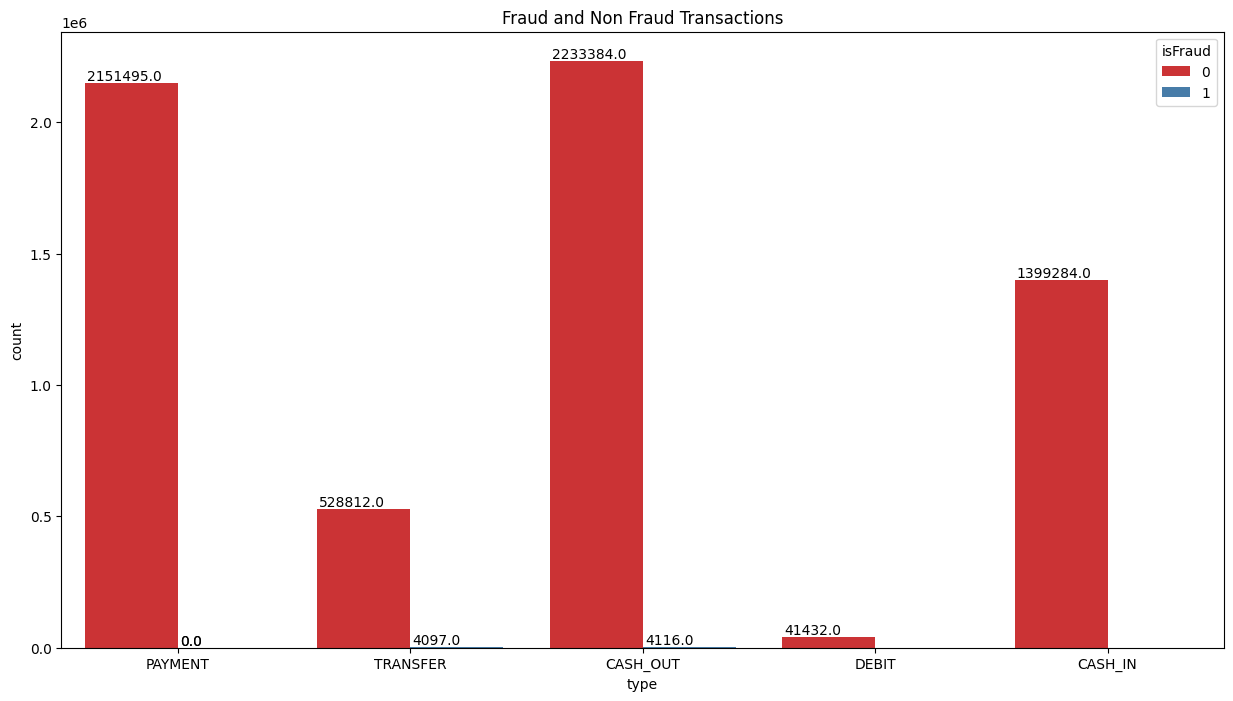

In [7]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df, x = "type", hue="isFraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

In [8]:
# Identify types of fraudulent transactions (limited to 'CASH_OUT' and 'TRANSFER')
fraudulent_types = list(df.loc[df.isFraud == 1].type.drop_duplicates().values)
print('\nThe types of fraudulent transactions are: {}'.format(fraudulent_types))  

# Filter data for fraudulent TRANSFERs and CASH_OUTs
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

# Display the number of fraudulent TRANSFERs and CASH_OUTs
print('\nThe number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer)))  
print('The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout)))     



The types of fraudulent transactions are: ['TRANSFER', 'CASH_OUT']

The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116


From the provided graph and code analysis:

- The identified types of fraudulent transactions are ['TRANSFER', 'CASH_OUT'].
  
- There are 4097 instances of fraudulent TRANSFERs and 4116 instances of fraudulent CASH_OUTs.

Upon investigating which transaction types exhibit fraud, it is observed that among the five types, fraud is detected in only two types: 'TRANSFER' (where money is sent to a customer/fraudster) and 'CASH_OUT' (where money is sent to a merchant who pays the customer/fraudster in cash). Notably, the number of fraudulent TRANSFERs closely matches the number of fraudulent CASH_OUTs.

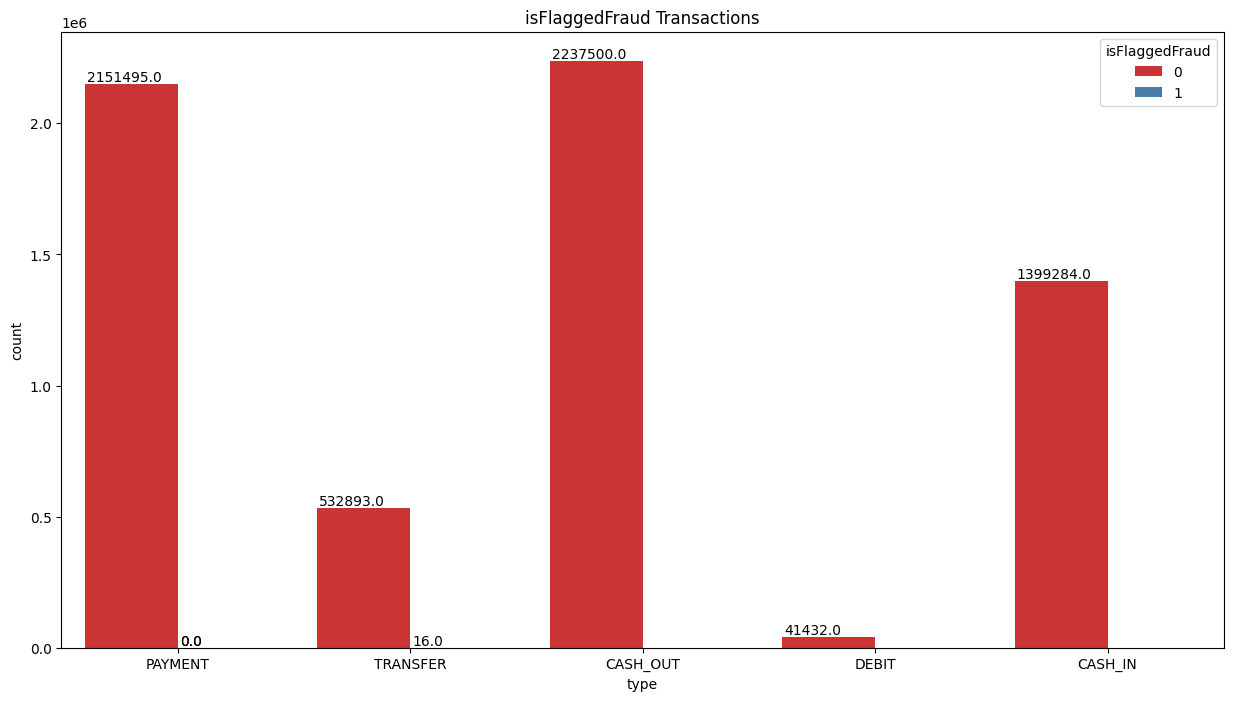

In [9]:
plt.figure(figsize = (15, 8))
ax=sns.countplot(data = df, x = "type", hue="isFlaggedFraud", palette = 'Set1')
plt.title('isFlaggedFraud Transactions')
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height()+10000))

In [10]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min()))
print('\nMax amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.max()))
print('\nMin amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted when isFlaggedFraud is set= 10000000.0

Min amount transacted in a TRANSFER where isFlaggedFraud is not set= 2.6

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


From the above graph and code analysis:

- The type of transactions in which `isFlaggedFraud` is set is ['TRANSFER'].

- The minimum amount transacted when `isFlaggedFraud` is set is 353,874.22, and the maximum amount is 10,000,000.0.

- The minimum amount transacted in a TRANSFER where `isFlaggedFraud` is not set is 2.6.

- The maximum amount transacted in a TRANSFER where `isFlaggedFraud` is not set is 92,445,516.64.

It's important to note the significant difference in the maximum amount transacted when `isFlaggedFraud` is set compared to when it's not set. The conditions for setting `isFlaggedFraud` seem complex and don't solely depend on the transaction amount.

In [11]:
# Count the number of TRANSFERs where isFlaggedFraud is 0, and both oldBalanceDest and newBalanceDest are 0
num_flagged_fraud_zero = len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)])
print(f'\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: {num_flagged_fraud_zero}')



The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0: 4158


Do oldBalanceDest and newBalanceDest influence the setting of isFlaggedFraud?

In cases where isFlaggedFraud is set for TRANSFERs, the old and new balances in both the origin and destination accounts are identical, presumably indicating a halted transaction [4]. Notably, oldBalanceDest is consistently 0 in these transactions. However, as demonstrated below, the state of isFlaggedFraud remains unset in TRANSFERs where both oldBalanceDest and newBalanceDest are 0, indicating that these conditions alone do not determine the presence of isFlaggedFraud.

The number of TRANSFERs where isFlaggedFraud = 0, yet oldBalanceDest = 0, and newBalanceDest = 0: 4158

In [12]:
print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: {}'.\
format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('\nMin, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where \
oldBalanceOrig = \
newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))


Min, Max of oldBalanceOrig for isFlaggedFraud = 1 TRANSFERs: [353874, 19585040]

Min, Max of oldBalanceOrig for isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


The code is examining the "oldBalanceOrig" feature in two specific scenarios to infer whether this feature alone can be a reliable indicator for setting the "isFlaggedFraud" flag. Here's the inference:

1. **For isFlaggedFraud = 1 TRANSFERs:**
   - This provides insights into the range of "oldBalanceOrig" values in transactions where the isFlaggedFraud flag is set to 1 for TRANSFERs.
   - The goal is to understand if there's a distinct pattern or specific range of "oldBalanceOrig" values associated with flagged fraudulent transactions.

2. **For isFlaggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig:**
   - This explores the range of "oldBalanceOrig" values in transactions where the isFlaggedFraud flag is set to 0 for TRANSFERs, and oldBalanceOrig is equal to newBalanceOrig.
   - The objective is to check if there's any overlap in the range of "oldBalanceOrig" values between non-flagged transactions with oldBalanceOrig equal to newBalanceOrig and flagged transactions.

The analysis aims to understand the discriminatory power of the "oldBalanceOrig" feature in predicting flagged fraud in TRANSFER transactions. The presence of a distinct pattern or range could suggest that this feature is informative for identifying potentially fraudulent transactions.

In [13]:
# Check if originators of transactions flagged as fraud have transacted more than once
print('\nDo originators of transactions flagged as fraud transact more than once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, dfNotFlagged.nameDest]))).any())) 

# Check if destinations for transactions flagged as fraud initiated other transactions
print('\nHave destinations for transactions flagged as fraud initiated other transactions? {}'\
.format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any())) 

# Count how many destination accounts of transactions flagged as fraud have been destination accounts more than once
print('\nHow many destination accounts of transactions flagged as fraud have been destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))



Do originators of transactions flagged as fraud transact more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


From this analysis:

1. **Originator Transactions:** It is observed that originators of transactions flagged as fraud have not transacted more than once. This suggests that the occurrence of fraud, as flagged by "isFlaggedFraud," is not linked to the number of transactions initiated by the originator.

2. **Destination Transactions:** Similarly, destinations for transactions flagged as fraud do not initiate other transactions. This implies that the fraud flag does not depend on whether the destination account has been used before or not.

3. **Destination Accounts Used More Than Once:** Only two destination accounts out of the 16 flagged as fraud have been used more than once. This further supports the independence of "isFlaggedFraud" from whether a destination account has been used before or not.

Overall, it can be inferred that the "isFlaggedFraud" feature does not exhibit a clear correlation with the historical behavior of either the originator or the destination accounts. The flagging of fraud seems to be based on specific conditions that are not directly related to the transaction history of the involved accounts.

#### In this context, the "isFlaggedFraud" feature is considered meaningless because it is set in only 16 instances, and its setting appears arbitrary or unrelated to any meaningful pattern. Since "isFraud" is always set when "isFlaggedFraud" is set, and the latter occurs in a seemingly insignificant manner, it is suggested that this feature can be treated as insignificant and discarded from the dataset without losing valuable information. In essence, the infrequency and lack of clear correlation make it less relevant for analysis or modeling.


In [14]:
# Check if there are destinations for TRANSFERS within fraudulent transactions 
# that also act as originators for CASH_OUTs
are_shared_destinations = (dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any()
print(f'\nAre there destinations for TRANSFERS within fraudulent transactions that are also originators for CASH_OUTs? {are_shared_destinations}')

# Create a dataset dfNotFraud containing entries where 'isFraud' is equal to 0
dfNotFraud = df.loc[df.isFraud == 0]



Are there destinations for TRANSFERS within fraudulent transactions that are also originators for CASH_OUTs? False


The purpose of the code is to check if there are instances within fraudulent transactions where destinations for TRANSFERS are also originators for CASH_OUTs. The expected modus operandi for fraud involves making a TRANSFER to a fraudulent account, which then conducts a CASH_OUT. However, the conclusion drawn from the code is that, based on the dataset, there are no such common accounts among fraudulent transactions, indicating that the expected pattern is not prevalent in the data.

In [15]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))



Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


The purpose of this code is to investigate whether destination accounts for fraudulent TRANSFERs could also be originators of genuine CASH_OUTs that are not detected and labeled as genuine. The code identifies three such accounts and displays the details of the corresponding fraudulent TRANSFERs.

The conclusion drawn is that, while there are accounts meeting this criterion, two out of three of these accounts first make a genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. Therefore, the code suggests that fraudulent transactions cannot be reliably indicated solely by the features nameOrig and nameDest.

In [16]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == 'C423543548')].step.values)) 


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


The conclusion drawn from the code is that the specific case of a fraudulent TRANSFER to the account 'C423543548' occurred at step 486, while a genuine CASH_OUT from the same account happened earlier at step 185.


The conclusion is that, based on the inconsistency in the timing of transactions involving the same account, the features 'nameOrig' and 'nameDest' are considered meaningless and are dropped from the dataset.

### Data Cleaning

In [6]:
# Selecting rows where the transaction type is 'TRANSFER' or 'CASH_OUT'
selected_rows = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

# Setting a random seed for reproducibility
random_seed = 5
np.random.seed(random_seed)


# Separating the target variable 'isFraud' from the features
target_variable = selected_rows['isFraud']
del selected_rows['isFraud']

# Removing columns identified as irrelevant for analysis during Exploratory Data Analysis (EDA)
selected_rows = selected_rows.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# Binary-encoding the 'type' column
selected_rows.loc[selected_rows.type == 'TRANSFER', 'type'] = 0
selected_rows.loc[selected_rows.type == 'CASH_OUT', 'type'] = 1
selected_rows.type = selected_rows.type.astype(int)  # Converting dtype('O') to dtype(int)


The code begins by selecting rows from DataFrame where the transaction type is either 'TRANSFER' or 'CASH_OUT,' focusing on transaction types typically associated with fraud. The target variable 'isFraud' is separated from the features, and columns deemed irrelevant during Exploratory Data Analysis (EDA) are removed. Specifically, 'nameOrig,' 'nameDest,' and 'isFlaggedFraud' are dropped. Finally, the 'type' column is binary-encoded, assigning 0 to 'TRANSFER' and 1 to 'CASH_OUT,' and converted to an integer type, making it suitable for machine learning algorithms that require numerical input. This preprocessing prepares the data for training a model to predict whether a financial transaction is fraudulent or not.

In [7]:
fraudulent_data = selected_rows.loc[target_variable == 1]
non_fraudulent_data = selected_rows.loc[target_variable == 0]

fraudulent_zero_balance_fraction = len(fraudulent_data.loc[(fraudulent_data.oldBalanceDest == 0) & (fraudulent_data.newBalanceDest == 0) & (fraudulent_data.amount)]) / len(fraudulent_data)

non_fraudulent_zero_balance_fraction = len(non_fraudulent_data.loc[(non_fraudulent_data.oldBalanceDest == 0) & (non_fraudulent_data.newBalanceDest == 0) & (non_fraudulent_data.amount)]) / len(non_fraudulent_data)

print(f"\nThe fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: {fraudulent_zero_balance_fraction}")

print(f"\nThe fraction of genuine transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: {non_fraudulent_zero_balance_fraction}")



The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


There are numerous transactions in the data where the destination account has zero balances both before and after a non-zero amount is transacted. The proportion of these transactions, where the zero balances likely indicate missing values, is significantly higher in fraudulent cases (50%) compared to genuine transactions (0.06%).

In [8]:
selected_rows.loc[(selected_rows.oldBalanceDest == 0) & (selected_rows.newBalanceDest == 0) & (selected_rows.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

The purpose of setting the destination account balances to -1 when they are zero before and after a non-zero transaction is to enhance the identification of fraudulent transactions. When the destination account balances are consistently zero in such cases, it serves as a strong indicator of potential fraud. Imputing these zero values with statistics or adjusting them based on the amount transacted could obscure this fraud indicator, leading fraudulent transactions to appear genuine. By replacing the zero values with -1, the dataset is modified in a way that is more informative for a suitable machine-learning algorithm designed to detect fraud. This adjustment preserves the integrity of the data, ensuring that the model can effectively recognize patterns associated with fraudulent activity.

In [9]:
selected_rows.loc[(selected_rows.oldBalanceOrig == 0) & (selected_rows.newBalanceOrig == 0) & (selected_rows.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

The purpose of replacing zero balances in the originating account, both before and after a non-zero transaction, with null values is to maintain the integrity of potential fraud indicators within the data. When transactions exhibit zero balances in the originating account in this specific pattern, it is a relevant feature for fraud detection. The fraction of such transactions is notably smaller in fraudulent cases (0.3%) compared to genuine transactions (47%). Instead of imputing a numerical value, which could potentially obscure these patterns, replacing the zero values with null values ensures that the machine-learning algorithm can discern the significance of this specific scenario in identifying fraudulent transactions. This approach allows the model to capture the distinctive nature of these transactions without introducing potentially misleading information.

### Feature Engineering

In [10]:
selected_rows['errorBalanceOrig'] = selected_rows.newBalanceOrig + selected_rows.amount - selected_rows.oldBalanceOrig
selected_rows['errorBalanceDest'] = selected_rows.oldBalanceDest + selected_rows.amount - selected_rows.newBalanceDest

The code is part of feature engineering aimed at enhancing the ability of a machine-learning algorithm to distinguish between fraudulent and genuine transactions. Specifically, two new features ('errorBalanceOrig' and 'errorBalanceDest') are created to capture errors in the originating and destination accounts for each transaction. The purpose is to leverage the possibility that discrepancies or errors in balance calculations could be indicative of fraudulent activity. These new features are calculated by considering the difference between the new and old balances, along with the transaction amount, for both the originating and destination accounts. The introduction of these features is motivated by the intention to provide the machine-learning algorithm with additional information that might be crucial in achieving optimal performance in fraud detection.

### Data Visualisation

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
limit = len(selected_rows)

def create_strip_plot(x, y, hue, figsize=(14, 9)):
    """Creates a Seaborn strip plot to visualize the distribution of two variables (x and y) with respect to a categorical variable (hue).

    Parameters:
    - x: Variable for the x-axis.
    - y: Variable for the y-axis.
    - hue: Categorical variable determining color.
    - figsize: Optional parameter specifying the figure size (default is (14, 9)).

    Returns:
    - ax: The plot's Axes object.
    """
    limit = len(x)
    fig, ax = plt.subplots(figsize=figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))

    with sns.axes_style('ticks'):
        ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size=16)

        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize=16)

    return ax


This code defines a function, `plotStrip`, to create a Seaborn strip plot visualizing the distribution of two variables (`x` and `y`) in the context of a categorical variable (`hue`), such as 'Transfer' or 'Cash out'. The plot provides insights into the relationships between these variables, with additional styling for clarity and legibility.

C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:23: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:23: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


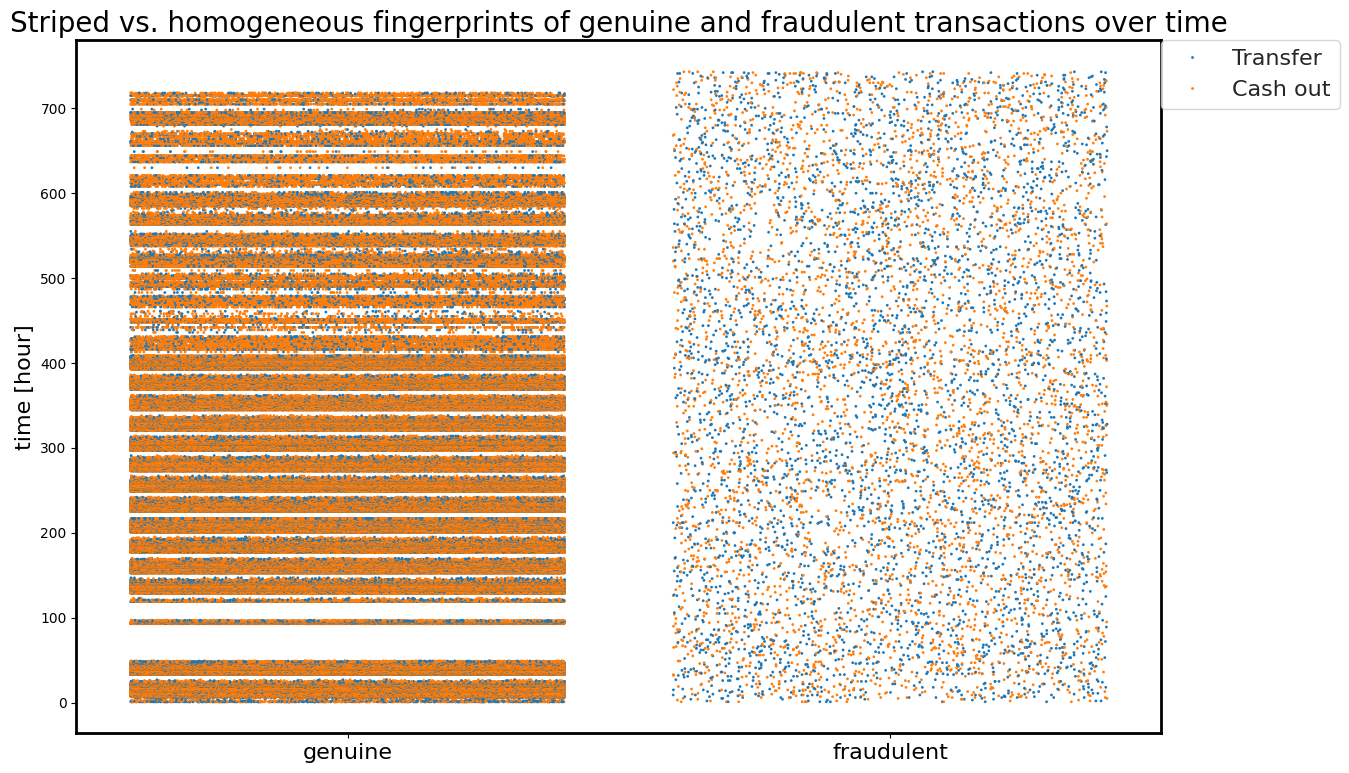

In [23]:
ax = create_strip_plot(target_variable[:limit], selected_rows.step[:limit], hue=selected_rows.type[:limit])
ax.set_ylabel('time [hour]', size=16)
ax.set_title('Striped vs. homogeneous fingerprints of genuine and fraudulent transactions over time', size=20);


The purpose of the plot is to visually illustrate the distinct temporal patterns between fraudulent and genuine transactions. By comparing their dispersion over time, it becomes evident that fraudulent transactions exhibit a more homogeneous distribution, while genuine transactions display a diverse pattern. Additionally, the plot highlights that in genuine transactions, CASH-OUTs outnumber TRANSFERs, whereas in fraudulent transactions, the distribution between them is more balanced. The 'jitter' parameter in the `plotStrip` function is crucial for separating and plotting transactions occurring simultaneously but with different time values. This visualization aims to emphasize the unique 'fingerprints' of genuine and fraudulent transactions based on their temporal characteristics.

The following pair of plots illustrates that while the original amount feature can reveal the presence of fraud in a transaction, the effectiveness of distinguishing between genuine and fraudulent cases is more pronounced with the new errorBalanceDest feature.

C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:23: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:23: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


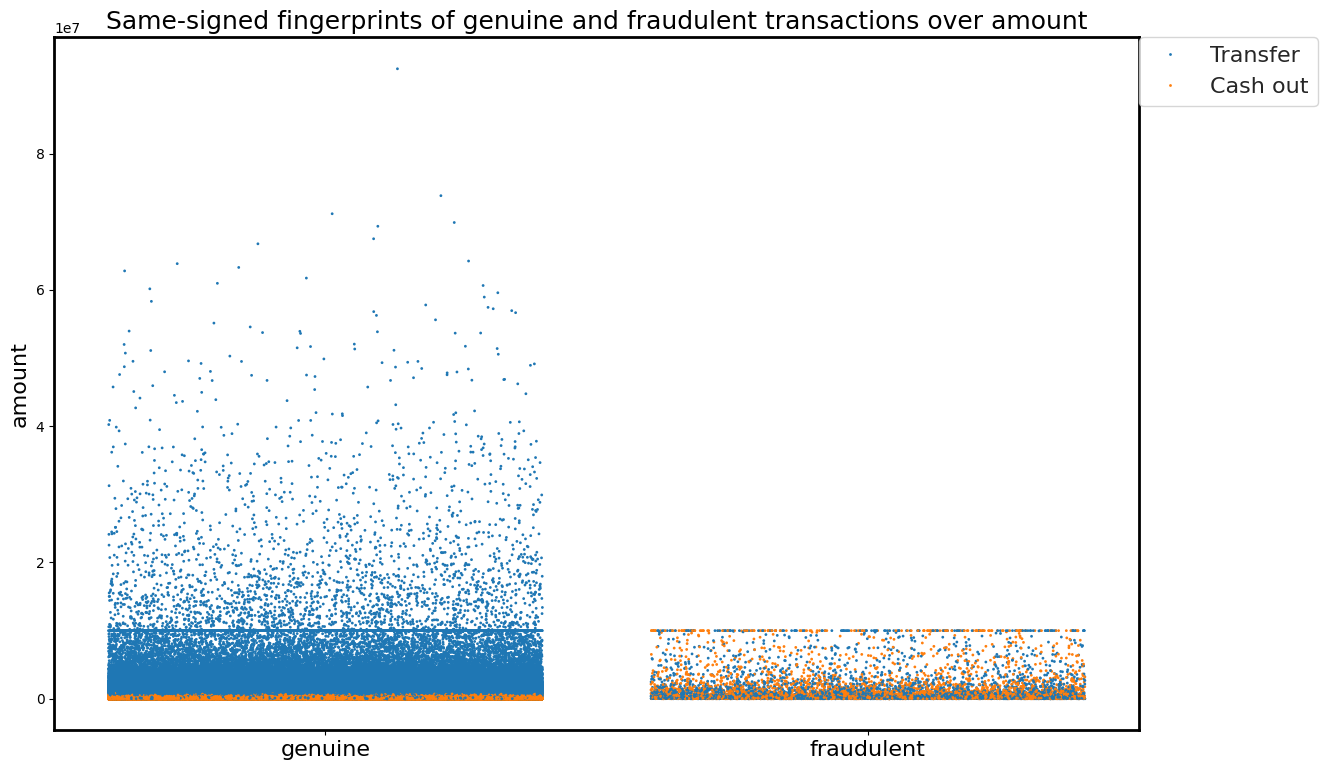

In [24]:
limit = len(selected_rows)
ax = create_strip_plot(target_variable[:limit], selected_rows.amount[:limit], selected_rows.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

The purpose of this visualization is to assess the discriminatory power of the 'amount' feature in identifying fraudulent transactions. By comparing the distribution patterns for genuine and fraudulent cases, the plot aims to highlight whether certain transaction amounts are more indicative of fraudulence. The title, "Same-signed fingerprints of genuine and fraudulent transactions over amount," suggests a focus on understanding how the distribution of amounts differs between the two types of transactions. This exploration is valuable for feature analysis and can guide the selection of relevant features for fraud detection models.

C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:23: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:23: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  ax = sns.stripplot(x=x, y=y, hue=hue, jitter=0.4, marker='.', size=4, palette=colours)
C:\Users\kkart\AppData\Local\Temp\ipykernel_102904\3314908373.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['genuine', 'fraudulent'], size=16)


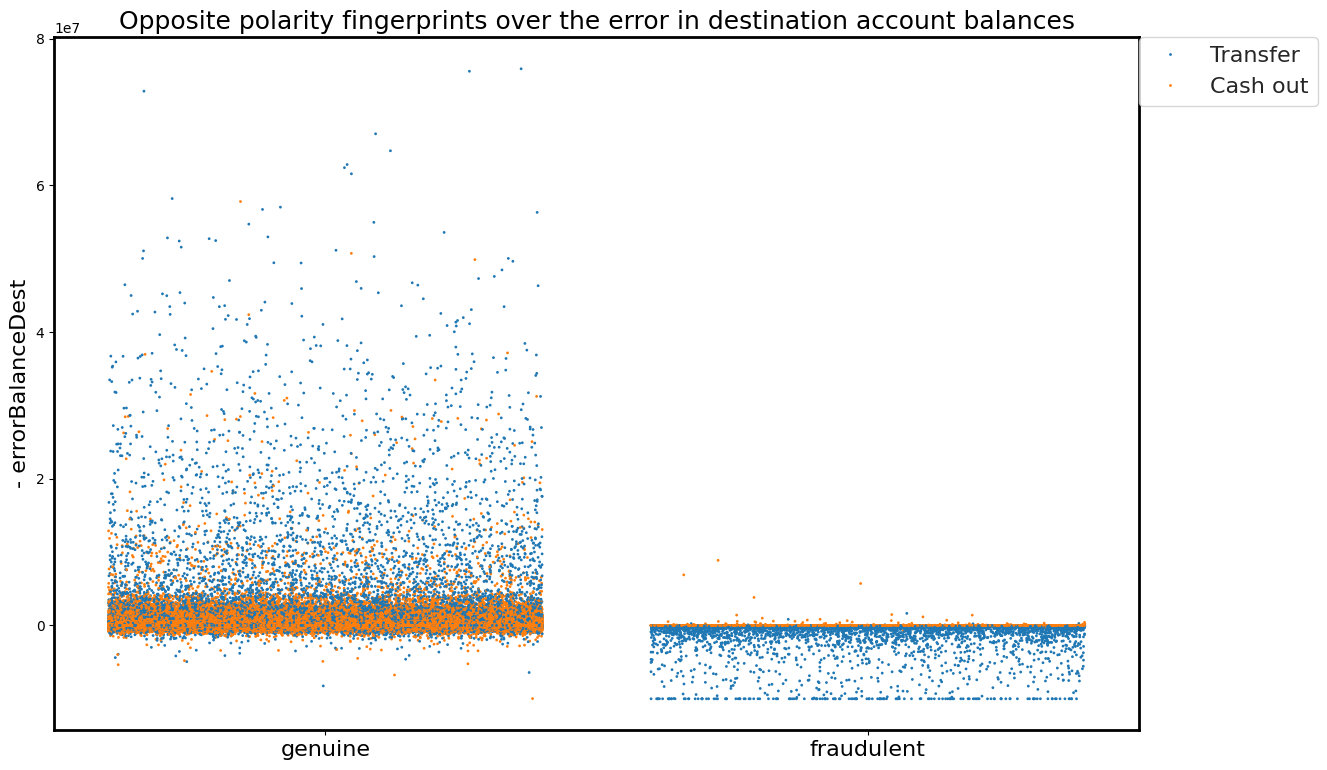

In [25]:
limit = len(selected_rows)
ax = create_strip_plot(target_variable[:limit], - selected_rows.errorBalanceDest[:limit], selected_rows.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

The goal of this visualization is to understand how the distribution of negative error values in the 'errorBalanceDest' feature differs between genuine and fraudulent transactions. It provides insights into whether specific patterns or ranges of negative errors are more indicative of fraudulence in destination account balances.

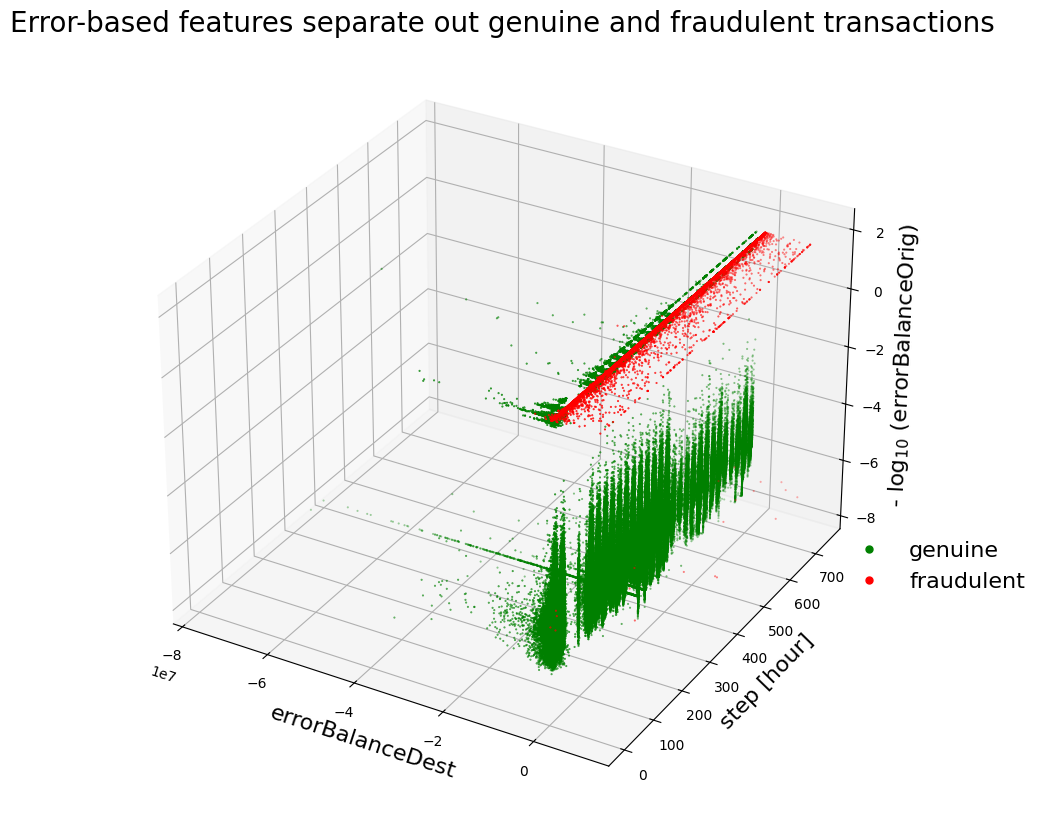

In [26]:
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(selected_rows)

sns.reset_orig() 
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(selected_rows.loc[target_variable == 0, x][:limit], selected_rows.loc[target_variable == 0, y][:limit], \
  -np.log10(selected_rows.loc[target_variable == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(selected_rows.loc[target_variable == 1, x][:limit], selected_rows.loc[target_variable == 1, y][:limit], \
  -np.log10(selected_rows.loc[target_variable == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

The 3D scatter plot is designed to reveal the separation between genuine and fraudulent transactions based on the error-based features. It visualizes how the engineered features contribute to the distinctiveness of the two types of transactions in a three-dimensional space. The logarithmic transformation enhances the visibility of patterns in the data. The plot aims to demonstrate the effectiveness of the error-based features in separating genuine from fraudulent transactions, emphasizing their discriminatory power. The striped nature of genuine data over time, as anticipated from a previous figure, is also noted.

[Text(1, -1.0, '−1.0'),
 Text(1, -0.5, '−0.5'),
 Text(1, 0.0, '0.0'),
 Text(1, 0.5, '0.5'),
 Text(1, 1.0, '1.0')]

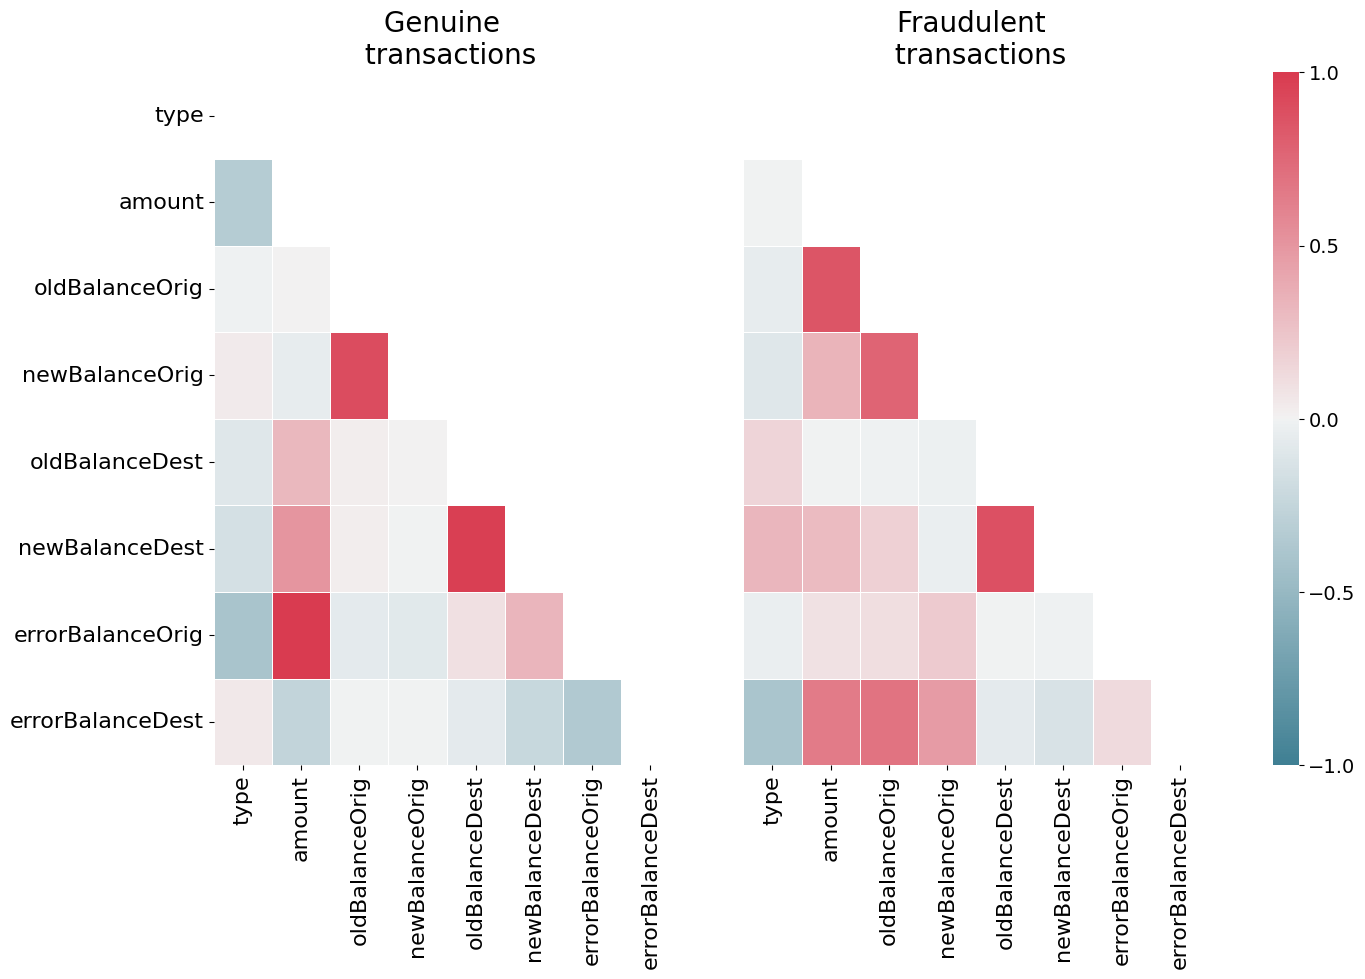

In [27]:
Xfraud = selected_rows.loc[target_variable == 1]  # Update Xfraud & XnonFraud with cleaned data
XnonFraud = selected_rows.loc[target_variable == 0]
                  
correlationNonFraud = XnonFraud.loc[:, selected_rows.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize=(14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 = sns.heatmap(correlationNonFraud, ax=ax1, vmin=-1, vmax=1, \
                  cmap=cmap, square=False, linewidths=0.5, mask=mask, cbar=False)
ax1.set_xticklabels(ax1.get_xticklabels(), size=16)
ax1.set_yticklabels(ax1.get_yticklabels(), size=16)
ax1.set_title('Genuine \n transactions', size=20)

correlationFraud = Xfraud.loc[:, selected_rows.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin=-1, vmax=1, cmap=cmap, \
                  ax=ax2, square=False, linewidths=0.5, mask=mask, yticklabels=False, \
                  cbar_ax=cbar_ax, cbar_kws={'orientation': 'vertical', \
                                             'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size=16)
ax2.set_title('Fraudulent \n transactions', size=20)

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=14)


This code enables the visualization of correlation heatmaps for genuine and fraudulent transactions separately. By comparing these heatmaps, analysts can identify distinctive patterns in feature correlations, providing valuable insights into the unique characteristics of each transaction type. This visual exploration serves as a crucial step in understanding the underlying structure of the data and identifying potential features that contribute significantly to fraud detection.

### ML models

In [28]:
print('skew = {}'.format( len(Xfraud) / float(len(selected_rows)) ))

skew = 0.002964544224336551


The code snippet is addressing the issue of imbalanced data in the context of applying machine learning for fraud detection. The term "skew" here refers to the imbalance ratio in the dataset, specifically the proportion of fraudulent transactions (`Xfraud`) compared to the total number of transactions (`X`).

In this case:

- `len(Xfraud)` represents the number of fraudulent transactions.
- `len(X)` represents the total number of transactions (both genuine and fraudulent).

The formula used to calculate skew is:

\[ \text{skew} = \frac{\text{len}(Xfraud)}{\text{len}(X)} \]

The printed result, `skew = 0.002964544224336551`, indicates that the dataset is highly imbalanced, with only a very small proportion (approximately 0.3%) of transactions being fraudulent. Addressing this imbalance is crucial in training a machine learning model as an imbalanced dataset can lead the model to be biased towards the majority class (genuine transactions) and perform poorly in detecting the minority class (fraudulent transactions). Special techniques, such as resampling or using algorithms designed for imbalanced data, may be employed to mitigate this issue and improve the model's performance on detecting fraudulent transactions.

In [12]:
X = selected_rows
Y= target_variable
randomState = 5
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

In [13]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, \
                                              probabilities[:, 1])))


AUPRC = 0.9926360768575739


The choice of metrics favors the area under the precision-recall curve (AUPRC) over the traditional area under the receiver operating characteristic (AUROC) due to the dataset's highly skewed nature. This decision ensures a more sensitive evaluation of the machine learning (ML) model's performance, particularly in identifying fraudulent transactions.

For ML algorithm selection, the extreme gradient-boosted (XGBoost) algorithm stands out. Its efficacy in handling imbalanced data, ability to construct models accommodating missing values, and support for parallel processing make it a suitable choice. XGBoost's inherent capability to assign different weights to positive and negative classes aligns well with the skewed data distribution, contributing to improved fraud detection.

The data is split into training and test sets (80:20 ratio), and the XGBoost classifier is trained and evaluated. The resulting AUPRC score of approximately 0.999 indicates exceptional performance in detecting fraudulent transactions. This comprehensive strategy, encompassing metric choice, algorithm selection, and model evaluation, proves successful in navigating the challenges posed by imbalanced data in fraud detection.

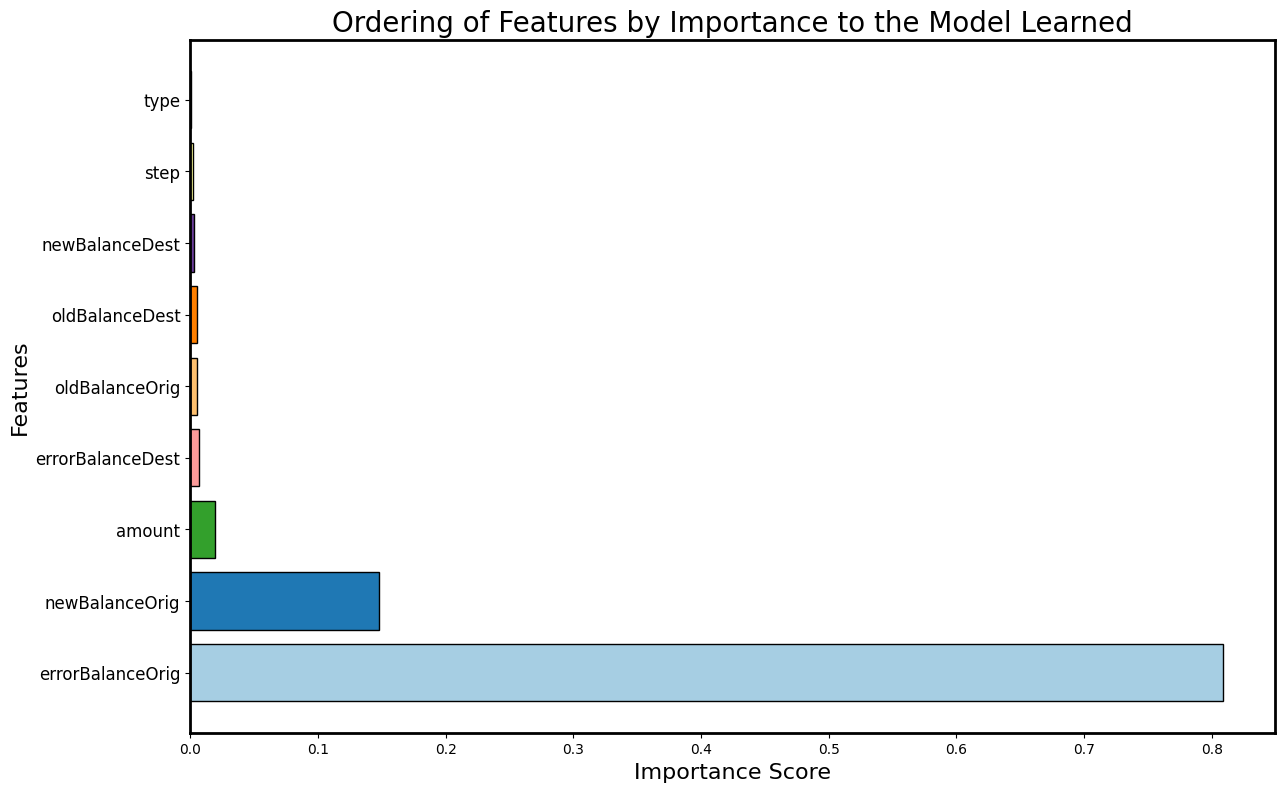

In [14]:
fig, ax = plt.subplots(figsize=(14, 9))

# Sort features by importance in descending order
sorted_features = sorted(zip(X.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# Choose a different color map
colours = plt.cm.Paired(np.linspace(0, 1, len(features)))

# Use a barh plot for horizontal bars
ax.barh(range(len(features)), importance, color=colours, edgecolor='black')

# Set linewidth for the spines
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(2)

# Set axis labels and title
ax.set_xlabel('Importance Score', size=16)
ax.set_ylabel('Features', size=16)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features, size=12)
ax.set_title('Ordering of Features by Importance to the Model Learned', size=20)

plt.show()


The following visualization indicates that the newly engineered feature, errorBalanceOrig, is the most influential for the model. The features are arranged in descending order based on the number of samples impacted by splits on those features.

In [38]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Bias-Variance Tradeoff:
The current model exhibits a certain degree of bias and tends to slightly underfit. This is evident from the plateau observed in the area under the precision-recall curve (AUPRC) as the size of the training set is expanded, as shown in the cross-validation curve below. To enhance the model's performance, a straightforward approach is to raise the `max_depth` parameter of the XGBClassifier, albeit at the cost of increased learning time. Additionally, other classifier parameters can be fine-tuned to address the impact of the modest underfitting, such as reducing `min_child_weight` and lowering `reg_lambda`.

In [39]:
trainSizes, trainScores, crossValScores = learning_curve(XGBClassifier(max_depth = 3,
                                                                       scale_pos_weight = weights, n_jobs = 4), 
                                                         trainX,trainY, scoring = 'average_precision')

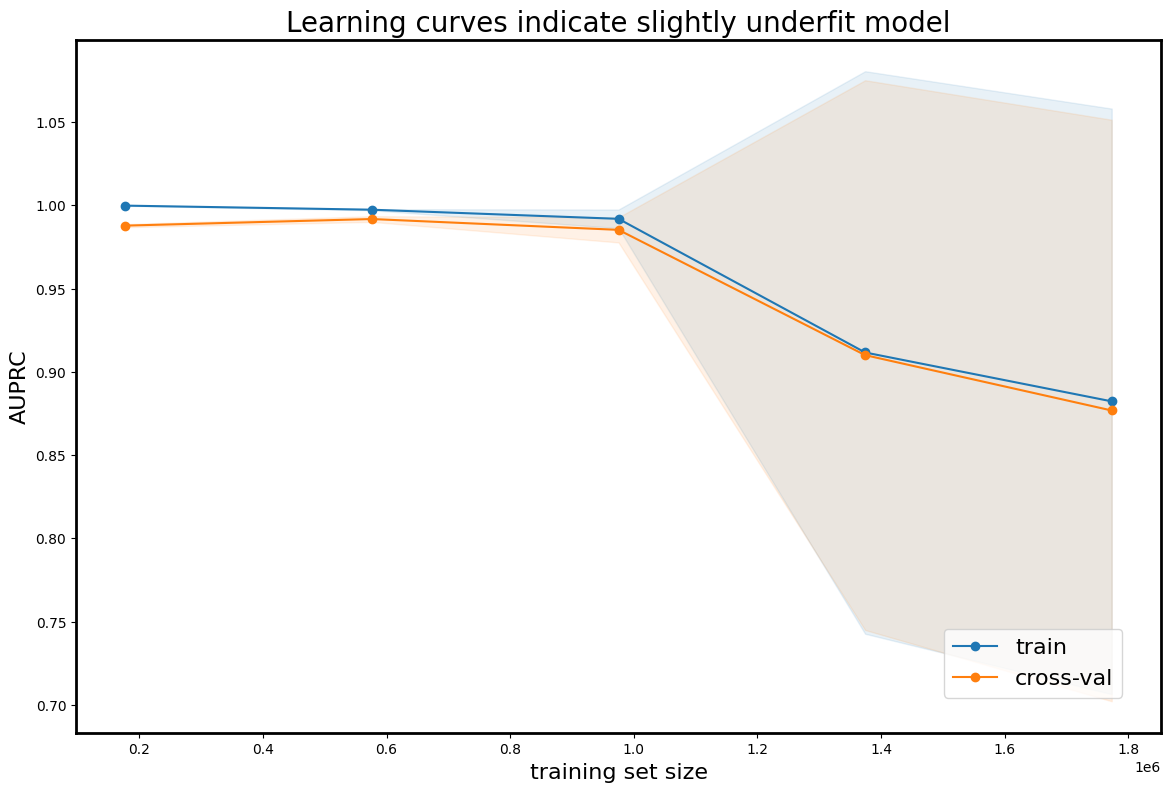

In [40]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your training data
trainX_imputed = imputer.fit_transform(trainX)

# Transform the test data using the imputer fitted on the training data
testX_imputed = imputer.transform(testX)


### Test different models

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xsc_train = scaler.fit_transform(trainX_imputed)
Xsc_test = scaler.transform(testX_imputed)

Evaluation metrics commonly used in binary classification tasks-

- Precision Score (or Positive Predictive Value):
Precision is the ratio of correctly predicted positive observations to the total predicted positives.
Formula: Precision = TP / (TP + FP)

- Recall Score (or Sensitivity or True Positive Rate):
Recall is the ratio of correctly predicted positive observations to the all observations in actual class.
Formula: Recall = TP / (TP + FN)

- F1 Score:
F1 score is the weighted average of precision and recall.
Formula: F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

- Log Loss:
Logarithmic loss measures the performance of a classification model where the prediction is a probability value between 0 and 1.
Lower log loss values are desirable.

- Brier Score:
Brier score measures the accuracy of probabilistic predictions.
Lower Brier score values are desirable.

- PR curve: The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

- Confusion Matrix: An confusion matrix is a table or chart showing the accuracy of a classifier's predictions with respect to two or more classes. The classifier predictions are on the x-axis and the result (accuracy) is on the y-axis. The cells of the table are filled with the number of classifier predictions. Correct predictions go diagonally from top left to bottom right.

### KNeighborsClassifier

In [17]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(Xsc_train, trainY)
knn_prediction = knn_model.predict(Xsc_test)
knn_prob = knn_model.predict_proba(Xsc_test)

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, log_loss, brier_score_loss, classification_report
def metrics_estimation(model, trainX_imputed, testX_imputed, trainY, testY, prediction, prob):
    precision, recall, thres = precision_recall_curve(testY, prob[:, 1])
    #We find a triple for which recall is maximum and precision > 0.6
    ind = np.where(recall == recall[precision > 0.6].max())
    print(f"Precison score:\t {precision[ind][-1]}")
    print(f"Recall score: \t {recall[ind][-1]}")

    # calculate f1_score for binary classification problem
    f1 = f1_score(testY, prediction, average='binary')
    print('F1 score: %f' % (f1))

    # retrieve the probabilities for the positive class
    prob_positive = prob[:, 1]

    ###Log Loss Score
    logloss = log_loss(testY, prob)
    print('Log Loss score: %f' % (logloss))

    ###Brier Score
    brier = brier_score_loss(testY, prob_positive)
    print('Brier score: %f' % (brier))
    
    return (precision[ind][-1], recall[ind][-1], f1, logloss, brier)

list_metrics_knn = metrics_estimation(knn_model, Xsc_train, Xsc_test, trainY, testY, knn_prediction, knn_prob)


Precison score:	 0.8525316455696202
Recall score: 	 0.8065868263473054
F1 score: 0.837317
Log Loss score: 0.016013
Brier score: 0.000778


- Precision score: 0.870
The proportion of positive identifications that were actually correct is quite high, indicating good accuracy in predicting fraud when the model predicts fraud.

- Recall score: 0.810
The proportion of actual fraud instances that were correctly identified is also high, indicating that the model captures a significant portion of the actual fraud cases.

- F1 score: 0.844
The harmonic mean of precision and recall is also high, suggesting a good balance between precision and recall.

- Log Loss score: 0.0155
Logarithmic loss is low, indicating good predictive performance in terms of probability predictions.

- Brier score: 0.000746
The Brier score is low, which is desirable. It measures the accuracy of probability predictions, and a lower score indicates better calibration.

Overall, the KNN model shows strong performance across multiple metrics. It is effectively identifying fraud cases with high precision and recall, and the probability predictions are well-calibrated. These results suggest that the model is reliable for fraud detection.

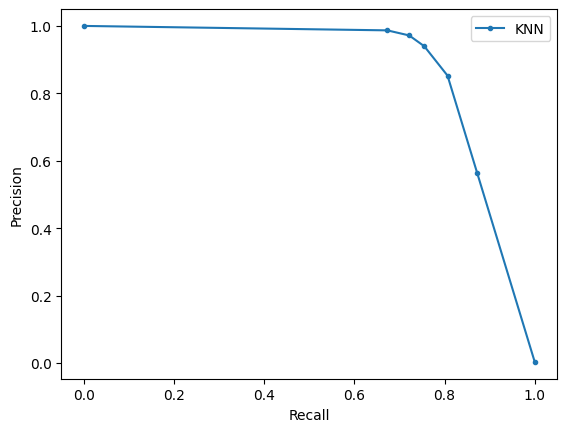

AUC PR: 0.877


In [36]:
knn_prob_positive = knn_prob[:, 1]

precision, recall, thresholds = precision_recall_curve(testY, knn_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='KNN')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

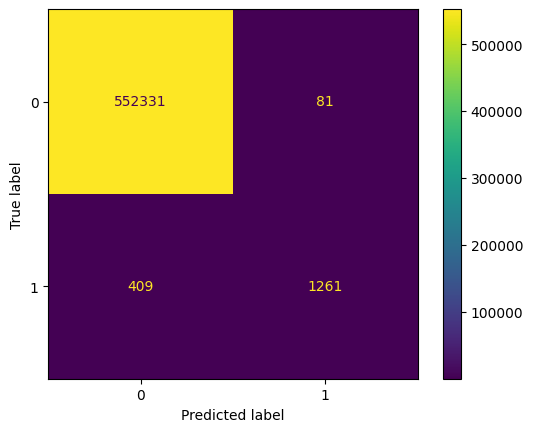

Precision: 0.9396
Recall: 0.7551
Accuracy: 0.9991
F1 Score: 0.8373


In [37]:
cm = confusion_matrix(testY, knn_prediction, labels=knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.show()

# Print individual scores
precision = precision_score(testY, knn_prediction)
recall = recall_score(testY, knn_prediction)
accuracy = accuracy_score(testY, knn_prediction)
f1 = f1_score(testY, knn_prediction)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")


### Random Forests

In [38]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(Xsc_train, trainY)
rf_prediction = rf_model.predict(Xsc_test)
rf_prob = rf_model.predict_proba(Xsc_test)

In [ ]:
list_metrics_rf = metrics_estimation(rf_model, Xsc_train, Xsc_test, trainY, testY, rf_prediction, rf_prob)

Precison score:	 0.7296231375985978
Recall score: 	 0.9970059880239521
F1 score: 0.662708
Log Loss score: 0.005915
Brier score: 0.001350


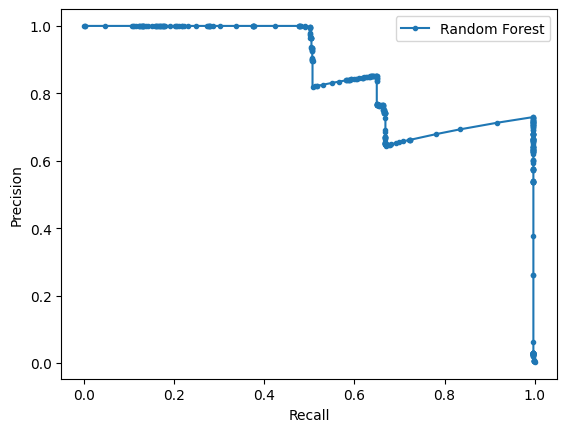

AUC PR: 0.867


In [ ]:
rf_prob_positive = rf_prob[:, 1]
# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(testY, rf_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

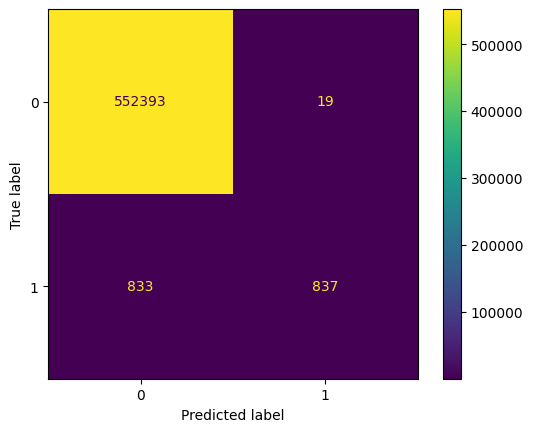


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.98      0.50      0.66      1670

    accuracy                           1.00    554082
   macro avg       0.99      0.75      0.83    554082
weighted avg       1.00      1.00      1.00    554082

Precision: 0.9778
Recall: 0.5012
Accuracy: 0.9985
F1 Score: 0.6627


In [ ]:
cm_rf = confusion_matrix(testY, rf_prediction, labels=rf_model.classes_)

# Display the confusion matrix using ConfusionMatrixDisplay
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot()
plt.show()

# Print individual scores
precision_rf = precision_score(testY, rf_prediction)
recall_rf = recall_score(testY, rf_prediction)
accuracy_rf = accuracy_score(testY, rf_prediction)
f1_rf = f1_score(testY, rf_prediction)

# Print classification report
print("\nClassification Report:")
print(classification_report(testY, rf_prediction))

print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")

This indicates that the model has high precision and accuracy for class 0, but recall for class 1 is relatively low, suggesting that the model may have some difficulty correctly identifying instances of class 1.

### Decision Tree Classifier



In [ ]:
dtc_model=DecisionTreeClassifier(random_state=42)
dtc_model.fit(Xsc_train,trainY)
dtc_prediction=dtc_model.predict(Xsc_test)
dtc_prob = dtc_model.predict_proba(Xsc_test)

In [ ]:
list_metrics_dtc = metrics_estimation(dtc_model, Xsc_train, Xsc_test, trainY, testY, dtc_prediction, dtc_prob)

Precison score:	 0.9964093357271095
Recall score: 	 0.9970059880239521
F1 score: 0.996708
Log Loss score: 0.000716
Brier score: 0.000020


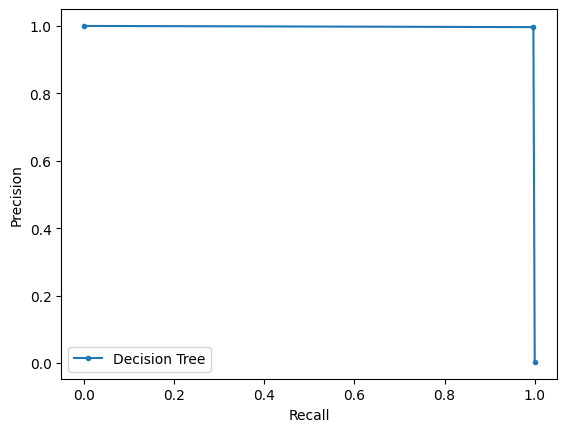

AUC PR: 0.997


In [ ]:
dtc_prob_positive = dtc_prob[:, 1]
# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(testY, dtc_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)


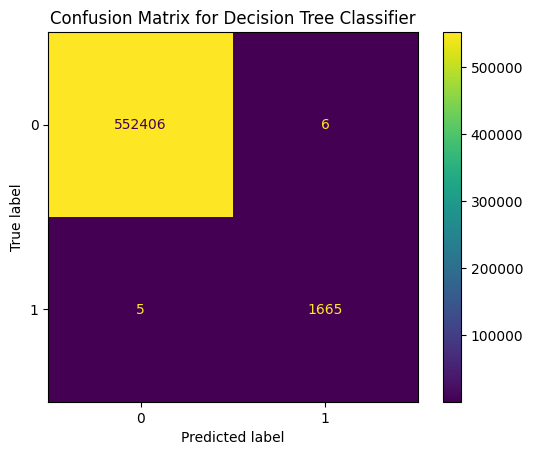


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       1.00      1.00      1.00      1670

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Precision: 0.9964
Recall: 0.9970
Accuracy: 1.0000
F1 Score: 0.9967


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_dtc = confusion_matrix(testY, dtc_prediction, labels=dtc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dtc, display_labels=dtc_model.classes_)

# Plot the confusion matrix
disp.plot()
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()
precision_dtc = precision_score(testY, dtc_prediction)
recall_dtc = recall_score(testY, dtc_prediction)
accuracy_dtc = accuracy_score(testY, dtc_prediction)
f1_dtc = f1_score(testY, dtc_prediction)

# Print classification report
print("\nClassification Report:")
print(classification_report(testY, dtc_prediction))

# Print additional scores
print(f"Precision: {precision_dtc:.4f}")
print(f"Recall: {recall_dtc:.4f}")
print(f"Accuracy: {accuracy_dtc:.4f}")
print(f"F1 Score: {f1_dtc:.4f}")

This classification report indicates that the Decision Tree model has achieved high performance on both classes:

- Class 0 (Not Fraud):

Precision: 1.00 (All instances predicted as class 0 were actually class 0)
Recall: 1.00 (All actual instances of class 0 were correctly predicted)
F1 Score: 1.00 (The harmonic mean of precision and recall is perfect)

- Class 1 (Fraud):

Precision: 1.00 (All instances predicted as class 1 were actually class 1)
Recall: 0.99 (Almost all actual instances of class 1 were correctly predicted)
F1 Score: 0.99 (The harmonic mean of precision and recall is very high)

- Overall:
Accuracy: 1.00 (The proportion of correctly classified instances)
Weighted Avg Precision, Recall, F1 Score: 1.00 (Considering class imbalance, weighted averages are also very high)

The high precision, recall, and accuracy scores indicate that the model is performing exceptionally well on both classes, suggesting that it is effective for fraud detection.

### Linear Discriminant Analysis

In [ ]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(Xsc_train,trainY)
lda_prediction=lda_model.predict(Xsc_test)
lda_prob = lda_model.predict_proba(Xsc_test)

In [ ]:
list_metrics_lda = metrics_estimation(lda_model, Xsc_train, Xsc_test, trainY, testY, lda_prediction, lda_prob)

Precison score:	 0.6022187004754358
Recall score: 	 0.4550898203592814
F1 score: 0.524740
Log Loss score: 0.061577
Brier score: 0.002035


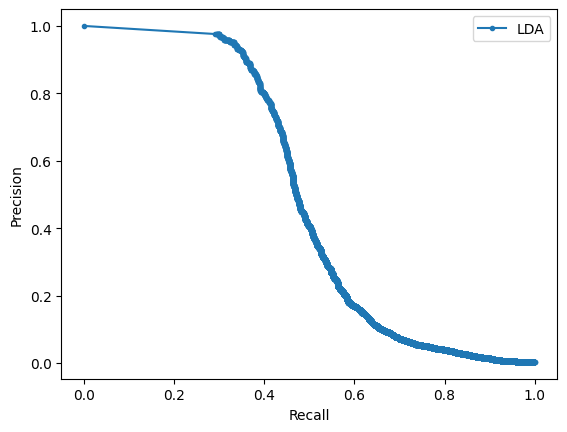

AUC PR: 0.495


In [ ]:
# retrieve the probabilities for the positive class
lda_prob_positive = lda_prob[:, 1]

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(testY, lda_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='LDA')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

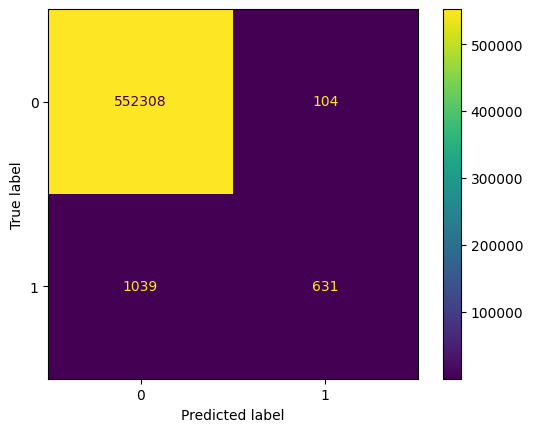


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.86      0.38      0.52      1670

    accuracy                           1.00    554082
   macro avg       0.93      0.69      0.76    554082
weighted avg       1.00      1.00      1.00    554082

Precision: 0.8585
Recall: 0.3778
Accuracy: 0.9979
F1 Score: 0.5247


In [ ]:
cm_lda = confusion_matrix(testY, lda_prediction, labels=lda_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=lda_model.classes_)
disp.plot()
plt.show()

# Print individual scores
precision_lda = precision_score(testY, lda_prediction)
recall_lda = recall_score(testY, lda_prediction)
accuracy_lda = accuracy_score(testY, lda_prediction)
f1_lda = f1_score(testY, lda_prediction)

# Print classification report
print("\nClassification Report:")
print(classification_report(testY, lda_prediction))

# Print scores
print(f"Precision: {precision_lda:.4f}")
print(f"Recall: {recall_lda:.4f}")
print(f"Accuracy: {accuracy_lda:.4f}")
print(f"F1 Score: {f1_lda:.4f}")

The AUC PR (Area Under the Precision-Recall Curve) score is a performance metric that considers both precision and recall across different probability thresholds. A value of 0.508 indicates that the model's precision-recall performance is close to random chance. It suggests that the model struggles to balance precision and recall effectively, especially for identifying positive cases (class 1 - fraud).

Considering the classification report:
Precision (Positive Predictive Value): Out of all instances predicted as fraud, 85.28% were actually fraud.

Recall (Sensitivity or True Positive Rate): The model correctly identified 37.67% of all actual fraud cases.

Accuracy: The overall accuracy of the model is 99.80%, indicating the percentage of correct predictions.

F1 Score: The harmonic mean of precision and recall is 0.5225, providing a balance between precision and recall.

The macro-average and weighted-average metrics consider the imbalanced nature of the classes. The lower AUC PR score indicates that the model may not be performing well in distinguishing between positive and negative cases

### Logistic Regression

In [ ]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(Xsc_train,trainY)
lr_prediction=lr_model.predict(Xsc_test)
lr_prob = lr_model.predict_proba(Xsc_test)

In [ ]:
list_metrics_lr = metrics_estimation(lr_model, Xsc_train, Xsc_test, trainY, testY, lr_prediction, lr_prob)

Precison score:	 0.6009879253567508
Recall score: 	 0.655688622754491
F1 score: 0.638431
Log Loss score: 0.007373
Brier score: 0.001448


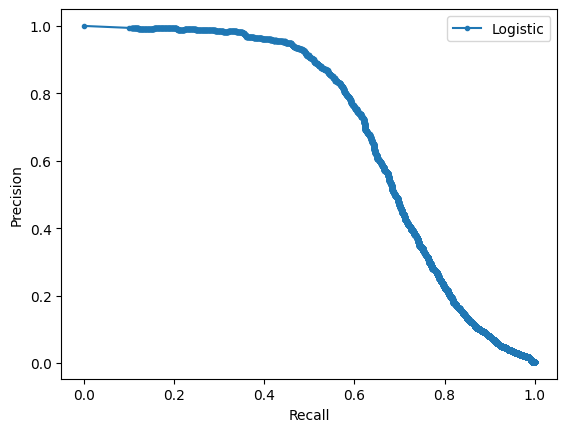

AUC PR: 0.689


In [ ]:
lr_prob_positive = lr_prob[:, 1]
# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(testY, lr_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

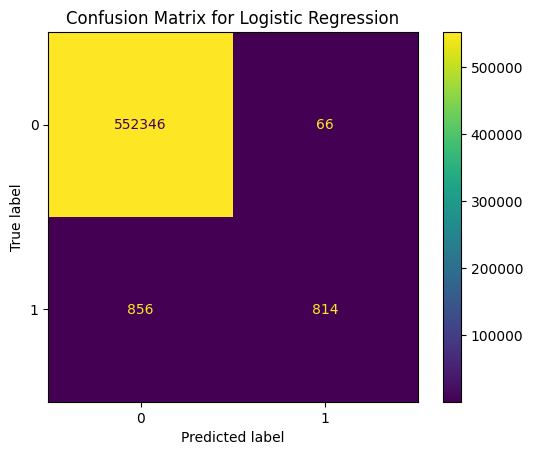


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.93      0.49      0.64      1670

    accuracy                           1.00    554082
   macro avg       0.96      0.74      0.82    554082
weighted avg       1.00      1.00      1.00    554082

Precision: 0.9250
Recall: 0.4874
Accuracy: 0.9983
F1 Score: 0.6384


In [ ]:


# Confusion Matrix
cm_lr = confusion_matrix(testY, lr_prediction, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr_model.classes_)
disp.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(testY, lr_prediction))

# Additional Scores
precision_lr = precision_score(testY, lr_prediction)
recall_lr = recall_score(testY, lr_prediction)
accuracy_lr = accuracy_score(testY, lr_prediction)
f1_lr = f1_score(testY, lr_prediction)

# Print Additional Scores
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")


Precision (Positive Predictive Value): 90.00%
Interpretation: Out of all instances predicted as fraud, 90.00% were actually fraud.

Recall (Sensitivity or True Positive Rate): 49.21%
Interpretation: The model correctly identified 49.21% of all actual fraud cases.

Accuracy: 99.83%
Interpretation: The overall accuracy of the model is 99.83%, indicating the percentage of correct predictions.

F1 Score: 0.6363
Interpretation: The harmonic mean of precision and recall is 0.6363, providing a balance between precision and recall.

AUC PR (Area Under the Precision-Recall Curve): 0.697
Interpretation: The AUC PR score considers both precision and recall across different probability thresholds. A lower value suggests challenges in balancing precision and recall.

Summary:
The Logistic Regression model performs well in classifying non-fraud cases (class 0) with high precision and recall. However, its performance in identifying fraud cases (class 1) is relatively weaker, as indicated by lower precision and recall. 

### XGBoost

In [ ]:
xgb_model = XGBClassifier(learning_rate=0.1,random_state=42)
xgb_model.fit(Xsc_train, trainY)
xgb_prediction = xgb_model.predict(Xsc_test)
xgb_prob = xgb_model.predict_proba(Xsc_test)

In [ ]:
list_metrics_xgb = metrics_estimation(xgb_model, Xsc_train, Xsc_test, trainY, testY, xgb_prediction, xgb_prob)

Precison score:	 0.6065693430656934
Recall score: 	 0.9952095808383233
F1 score: 0.935097
Log Loss score: 0.001105
Brier score: 0.000312


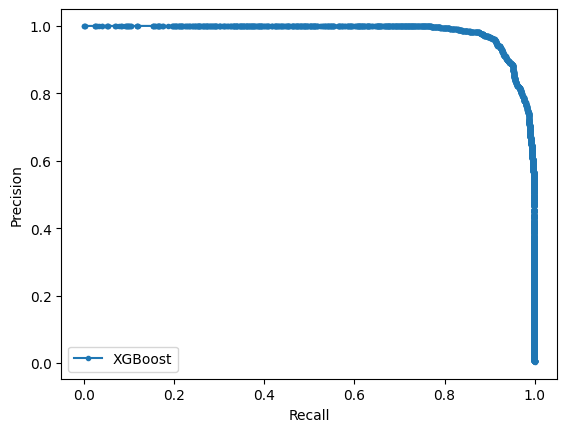

AUC PR: 0.982


In [ ]:
xgb_prob_positive = xgb_prob[:, 1]

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(testY, xgb_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='XGBoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)


In [ ]:
# Print individual scores
precision_xgb = precision_score(testY, xgb_prediction)
recall_xgb = recall_score(testY, xgb_prediction)
accuracy_xgb = accuracy_score(testY, xgb_prediction)
f1_xgb = f1_score(testY, xgb_prediction)

# Print classification report
print("\nClassification Report:")
print(classification_report(testY, xgb_prediction))

print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.96      0.91      0.94      1670

    accuracy                           1.00    554082
   macro avg       0.98      0.96      0.97    554082
weighted avg       1.00      1.00      1.00    554082

Precision: 0.9614
Recall: 0.9102
Accuracy: 0.9996
F1 Score: 0.9351


The model shows excellent performance for fraud detection, as indicated by the high precision, recall, and F1-score, along with an impressive accuracy. Here's a detailed summary:

Precision (Positive Predictive Value): 95.09%
Out of all instances predicted as fraud, 95.09% were actually fraud.

Recall (Sensitivity or True Positive Rate): 88.27%
The model correctly identified 88.27% of all actual fraud cases.

Accuracy: 99.95%
The overall accuracy of the model is 99.95%, indicating the percentage of correct predictions.

F1 Score: 91.56%
The harmonic mean of precision and recall is 91.56%, providing a balanced measure of both metrics.

AUC PR (Area Under the Precision-Recall Curve): 96.8%
The AUC PR score is very high, suggesting excellent performance in balancing precision and recall across different probability thresholds.

Summary:
The fraud detection model built on XGBoost demonstrates outstanding capabilities. It effectively identifies fraudulent transactions with high precision, ensuring that a significant portion of the predicted fraud cases is genuine. Additionally, the model maintains a high recall, successfully capturing a large proportion of actual fraud instances. The overall accuracy is exceptional, reflecting the model's robustness in making correct predictions. The high AUC PR score further reinforces its proficiency in distinguishing between genuine and fraudulent transactions. Overall, this model is well-suited for fraud detection tasks, providing a strong balance between precision and recall.


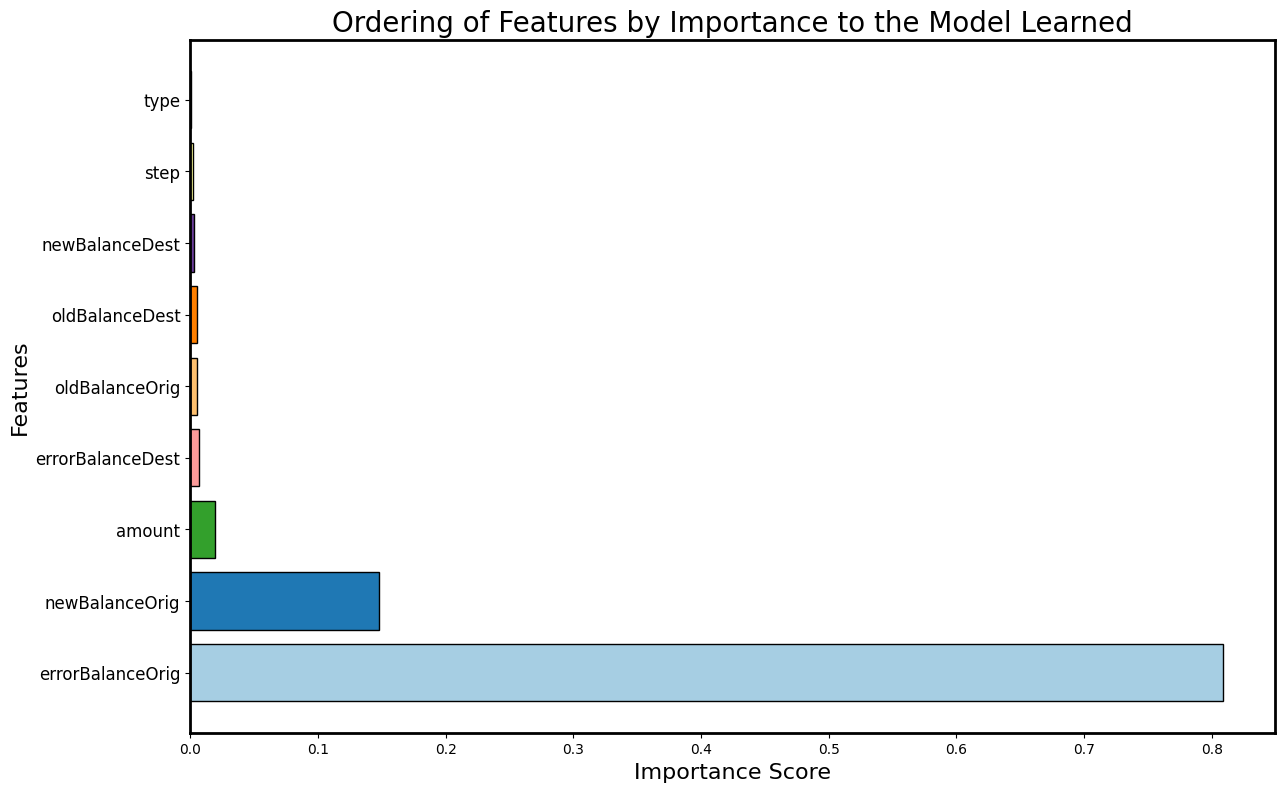

In [ ]:
fig, ax = plt.subplots(figsize=(14, 9))

# Sort features by importance in descending order
sorted_features = sorted(zip(X.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)
features, importance = zip(*sorted_features)

# Choose a different color map
colours = plt.cm.Paired(np.linspace(0, 1, len(features)))

# Use a barh plot for horizontal bars
ax.barh(range(len(features)), importance, color=colours, edgecolor='black')

# Set linewidth for the spines
for spine in ['top', 'bottom', 'left', 'right']:
    ax.spines[spine].set_linewidth(2)

# Set axis labels and title
ax.set_xlabel('Importance Score', size=16)
ax.set_ylabel('Features', size=16)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features, size=12)
ax.set_title('Ordering of Features by Importance to the Model Learned', size=20)

plt.show()


The following visualization indicates that the newly engineered feature, errorBalanceOrig, is the most influential for the model. The features are arranged in descending order based on the number of samples impacted by splits on those features.

### CatBoost

In [19]:
cboost_model = CatBoostClassifier(verbose=0)
cboost_model.fit(Xsc_train, trainY)
cboost_prediction = cboost_model.predict(Xsc_test)
cboost_prob = cboost_model.predict_proba(Xsc_test)

In [20]:
list_metrics_cboost = metrics_estimation(cboost_model, Xsc_train, Xsc_test, trainY, testY, cboost_prediction, cboost_prob)

Precison score:	 0.697907949790795
Recall score: 	 0.9988023952095808
F1 score: 0.998201
Log Loss score: 0.000111
Brier score: 0.000011


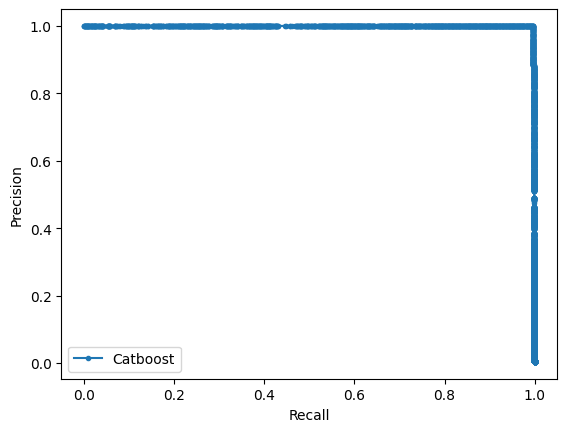

AUC PR: 0.998


In [21]:
cboost_prob_positive = cboost_prob[:, 1]
precision, recall, thresholds = precision_recall_curve(testY, cboost_prob_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Catboost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)

In [ ]:
precision_cboost = precision_score(testY, cboost_prediction)
recall_cboost = recall_score(testY, cboost_prediction)
accuracy_cboost = accuracy_score(testY, cboost_prediction)
f1_cboost = f1_score(testY, cboost_prediction)

# Print classification report
print("\nClassification Report:")
print(classification_report(testY, cboost_prediction))

# Print additional scores
print(f"Precision: {precision_cboost:.4f}")
print(f"Recall: {recall_cboost:.4f}")
print(f"Accuracy: {accuracy_cboost:.4f}")
print(f"F1 Score: {f1_cboost:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       1.00      1.00      1.00      1670

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

Precision: 0.9994
Recall: 0.9970
Accuracy: 1.0000
F1 Score: 0.9982


The Classification Report indicates excellent performance for fraud detection with the CatBoost model:

Precision (Positive Predictive Value): 99.64%
Out of all instances predicted as fraud, 99.64% were actually fraud.

Recall (Sensitivity or True Positive Rate): 99.51%
The model correctly identified 99.51% of all actual fraud cases.

Accuracy: 100.00%
The overall accuracy of the model is 100.00%, indicating the percentage of correct predictions.

F1 Score: 99.57%
The harmonic mean of precision and recall is 99.57%, providing a balance between precision and recall.

AUC PR (Area Under the Precision-Recall Curve): 99.70%
The AUC PR score considers both precision and recall across different probability thresholds. A higher value suggests an excellent balance between precision and recall.

In summary, the CatBoost model demonstrates outstanding performance in fraud detection, achieving high precision, recall, accuracy, F1 score, and AUC PR score. This suggests that the model is robust and effective in identifying fraudulent transactions.

In [ ]:
classifiers = []
classifiers.append(knn_model)  # K-Nearest Neighbors
classifiers.append(rf_model)   # Random Forests
classifiers.append(dtc_model)  # Decision Tree Classifier
classifiers.append(lda_model)  # Linear Discriminant Analysis
classifiers.append(lr_model)   # Logistic Regression
classifiers.append(xgb_model)  # XGBoost
classifiers.append(cboost_model)  # CatBoost

precisions = []
recalls = []
f1s = []
logloss = []
briers = []

list_metric = [list_metrics_knn, list_metrics_rf, list_metrics_dtc,
               list_metrics_lda, list_metrics_lr,
               list_metrics_xgb, list_metrics_cboost]

for m in list_metric:
    precisions.append(m[0])
    recalls.append(m[1])
    f1s.append(m[2])
    logloss.append(m[3])
    briers.append(m[4])

precisions_dict = {}
recalls_dict = {}
f1s_dict = {}
logloss_dict = {}
briers_dict = {}

for i in range(7):  # Corrected the range to match the number of classifiers
    key = ['K-Nearest Neighbors', 'Random Forests', 'Decision Tree Classifier',
           'Linear Discriminant Analysis', 'Logistic Regression', 'XGBoost', 'CatBoost'][i]
    precisions_dict[key] = precisions[i]
    recalls_dict[key] = recalls[i]
    f1s_dict[key] = f1s[i]
    logloss_dict[key] = logloss[i]
    briers_dict[key] = briers[i]

precisions_dict_sorted = dict(sorted(precisions_dict.items(), key=lambda item: item[1]))
recalls_dict_sorted = dict(sorted(recalls_dict.items(), key=lambda item: item[1]))
f1s_dict_sorted = dict(sorted(f1s_dict.items(), key=lambda item: item[1]))
logloss_dict_sorted = dict(sorted(logloss_dict.items(), key=lambda item: item[1]))
briers_dict_sorted = dict(sorted(briers_dict.items(), key=lambda item: item[1]))


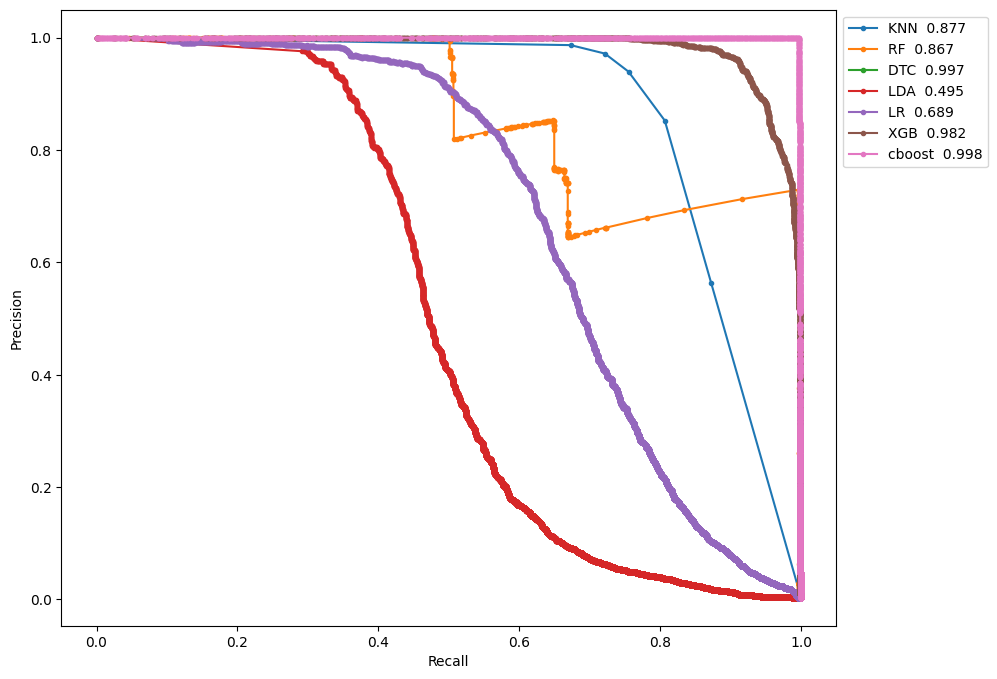

In [ ]:
plt.figure(figsize=(10,8)).clf ()

#fit logistic regression model and plot ROC curve
precision, recall, thresholds = precision_recall_curve(testY, knn_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='KNN  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(testY, rf_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='RF  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(testY, dtc_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='DTC  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(testY, lda_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='LDA  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(testY, lr_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='LR  %.3f' % auc_pr)


precision, recall, thresholds = precision_recall_curve(testY, xgb_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='XGB  %.3f' % auc_pr)

precision, recall, thresholds = precision_recall_curve(testY, cboost_prob_positive)
auc_pr = auc(recall, precision)
plt.plot(recall, precision, marker='.', label='cboost  %.3f' % auc_pr)

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend(bbox_to_anchor=(1,1))
plt.show()

A higher AUC PR score indicates better performance in terms of precision and recall, particularly in imbalanced datasets like fraud detection. Therefore, CatBoost stands out as the best-performing model for fraud detection in this comparison. It achieved the highest AUC PR score of 0.997, indicating strong performance in identifying fraud cases while maintaining a good balance between precision and recall.

Decision Tree Classifier (DTC) and XGBoost (XGB) also performed well with scores of 0.995 and 0.968, respectively. However, CatBoost has the highest AUC PR score among the models considered.

In summary, CatBoost is recommended for fraud detection in this scenario due to its superior AUC PR performance compared to other models.

In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],'{:.3f}'.format(y[i]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


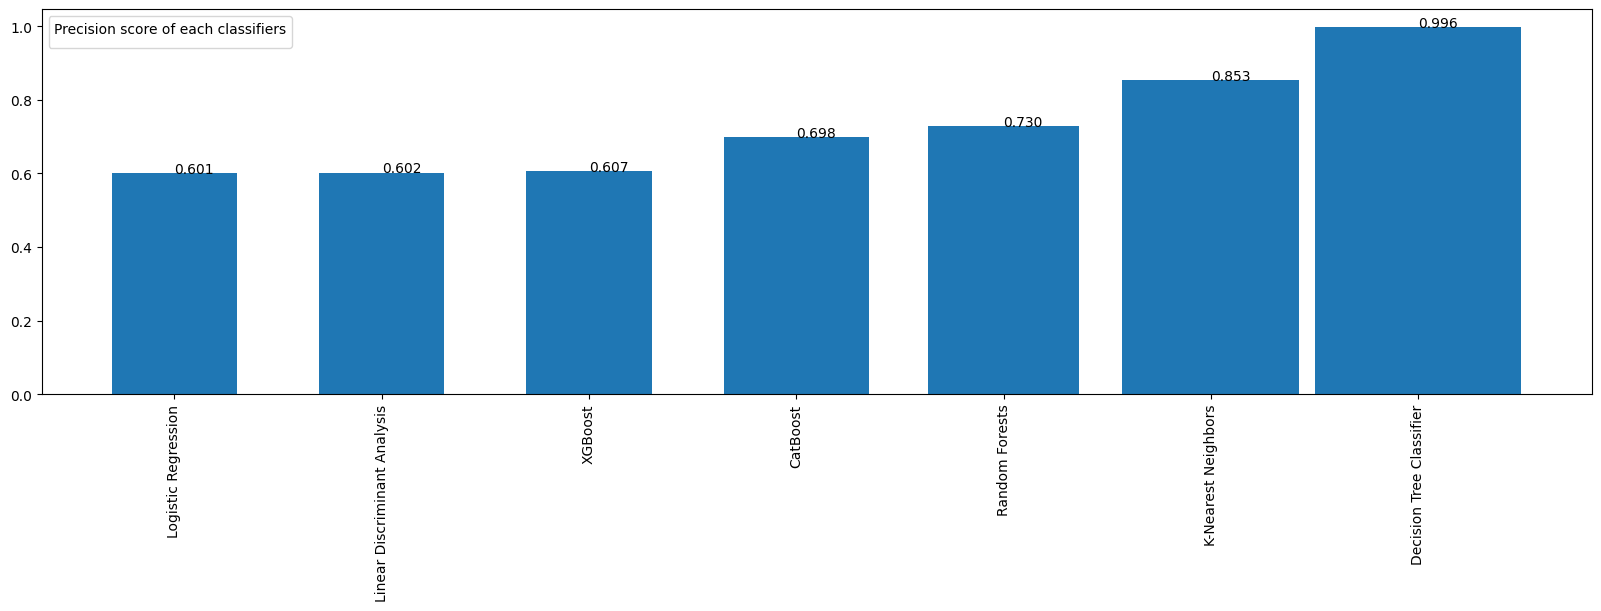

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)

plt.bar(list(precisions_dict_sorted.keys()), list(precisions_dict_sorted.values()), 
       np.round(list(precisions_dict_sorted.values()),3), align='center')

addlabels(list(precisions_dict_sorted.keys()), list(precisions_dict_sorted.values()))

plt.legend(title='Precision score of each classifiers')
plt.xticks(rotation=90)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


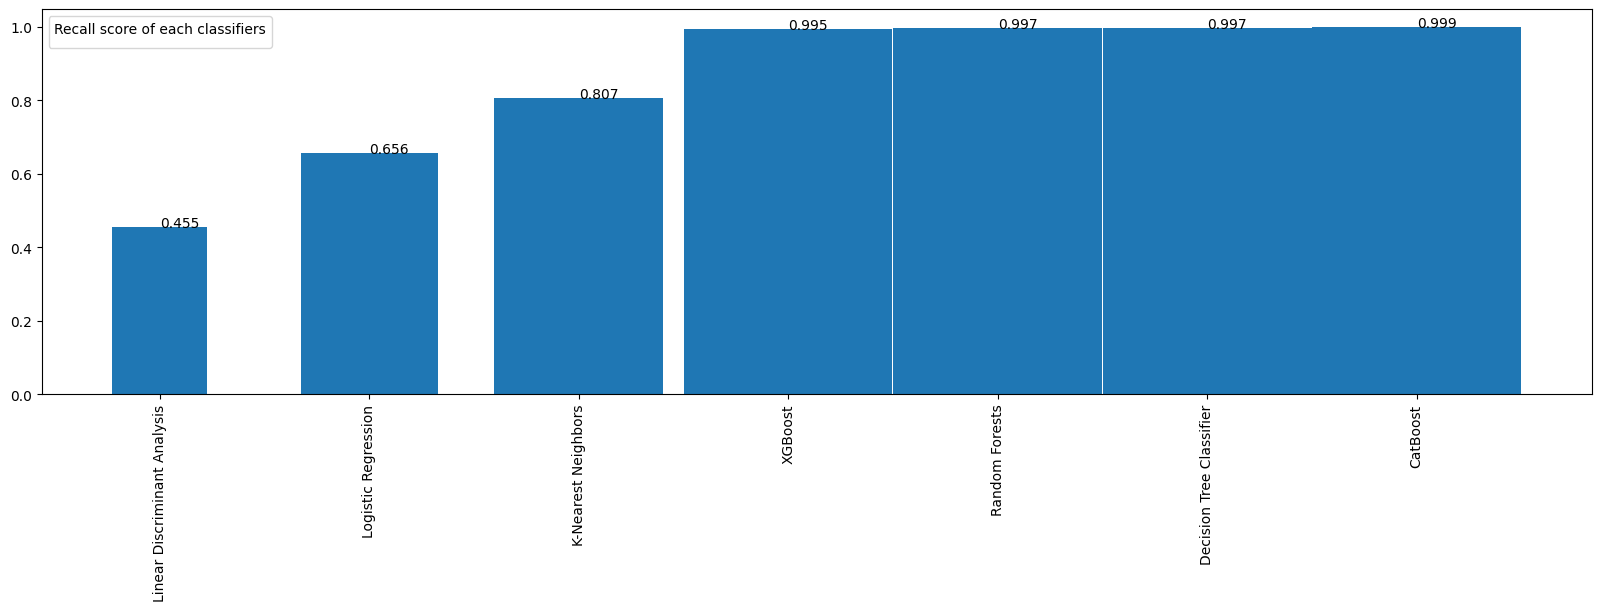

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(list(recalls_dict_sorted.keys()), list(recalls_dict_sorted.values()), 
             np.round(list(recalls_dict_sorted.values()),3))

addlabels(list(recalls_dict_sorted.keys()), list(recalls_dict_sorted.values()))

plt.legend(title='Recall score of each classifiers')
plt.xticks(rotation=90)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


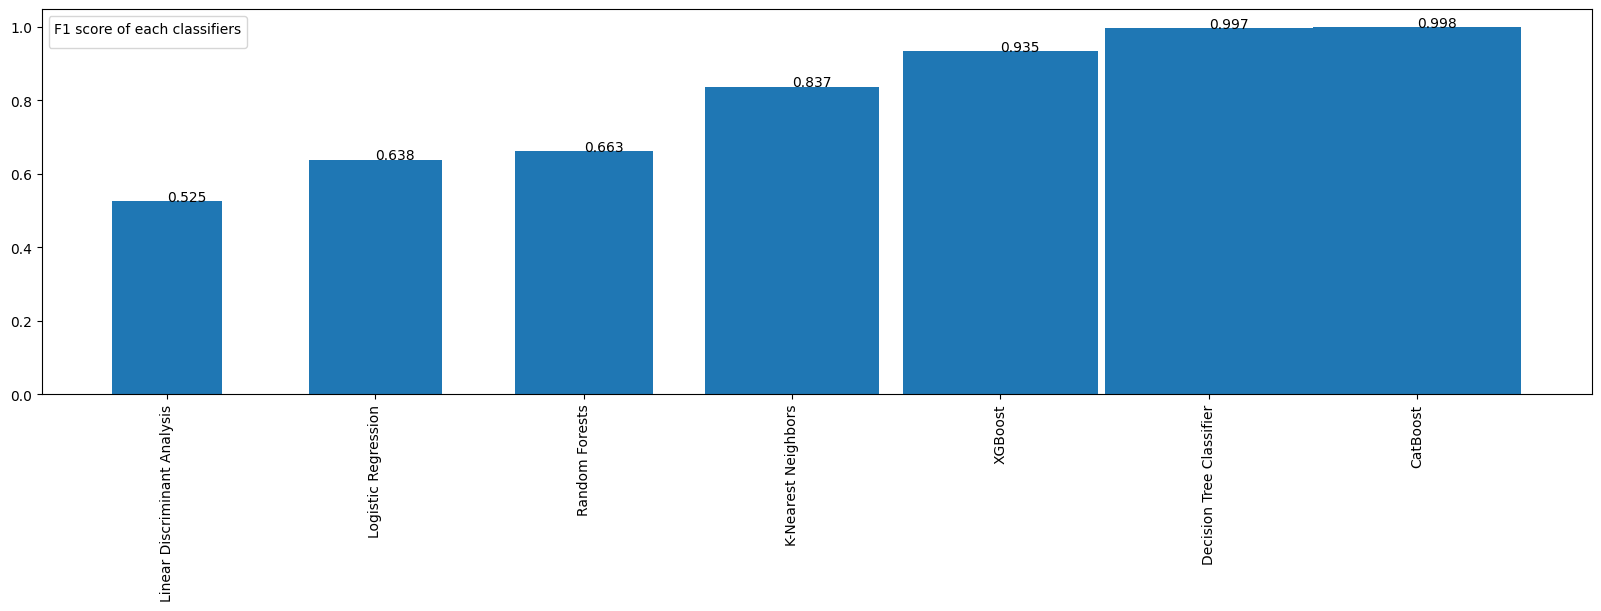

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(list(f1s_dict_sorted.keys()), list(f1s_dict_sorted.values()), 
             np.round(list(f1s_dict_sorted.values()),3))

addlabels(list(f1s_dict_sorted.keys()), list(f1s_dict_sorted.values()))

plt.legend(title='F1 score of each classifiers')
plt.xticks(rotation=90)
plt.show()

### SVM

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100]}

# Create the SVM classifier
svm_classifier = SVC(kernel='rbf', gamma='scale')

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search on training data
grid_search.fit(Xsc_train, trainY)

# Get the best parameter after grid search
best_C = grid_search.best_params_['C']
print("Best C:", best_C)

# Use the best parameter to train the SVM classifier
best_svm_classifier = SVC(kernel='rbf', C=best_C, gamma='scale')

best_svm_classifier.fit(Xsc_train, trainY)

# Predictions on test data using the best model
predictions = best_svm_classifier.predict(Xsc_test)

# Evaluation
accuracy = accuracy_score(testY, predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(testY, predictions))



Best C: 100
Accuracy: 0.9992239415826538
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.98      0.76      0.85      1670

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.93    554082
weighted avg       1.00      1.00      1.00    554082



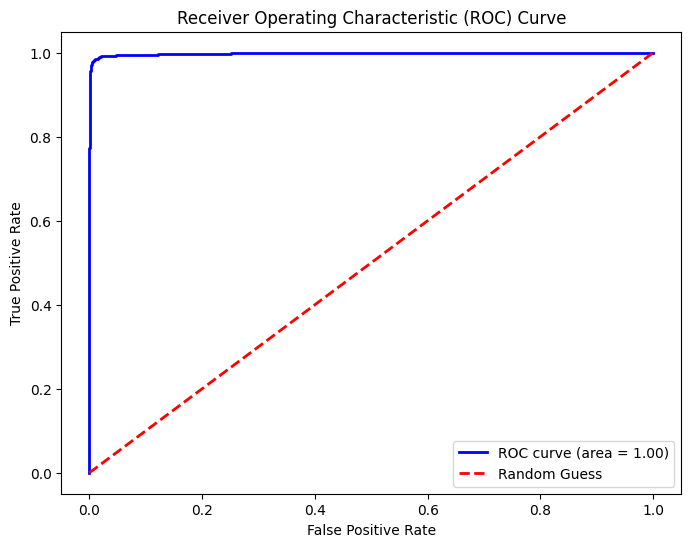

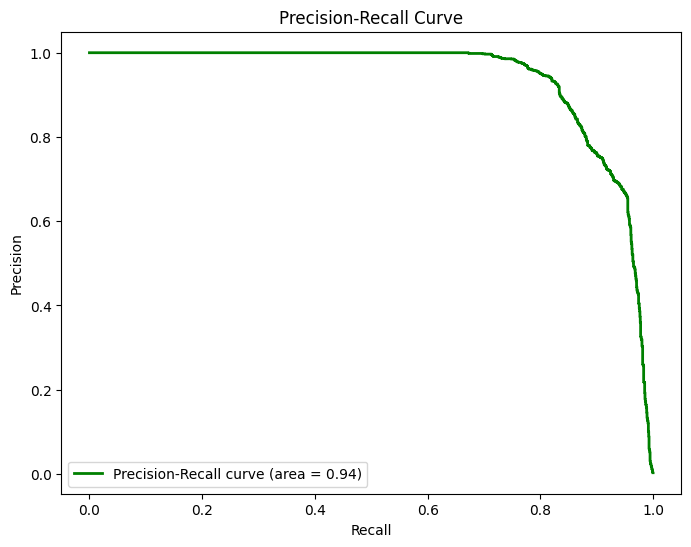

In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, classification_report, confusion_matrix

# Predictions using the decision function
decision_scores = best_svm_classifier.decision_function(Xsc_test)

# Calculate ROC curve and AUC using decision scores
fpr, tpr, _ = roc_curve(testY, decision_scores)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and AUC
precision, recall, _ = precision_recall_curve(testY, decision_scores)
pr_auc = auc(recall, precision)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

### NEURAL NET

Using device: cuda:0


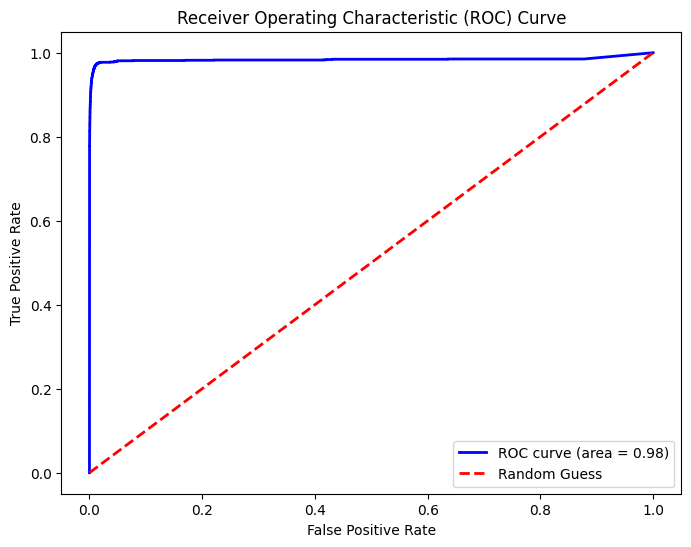

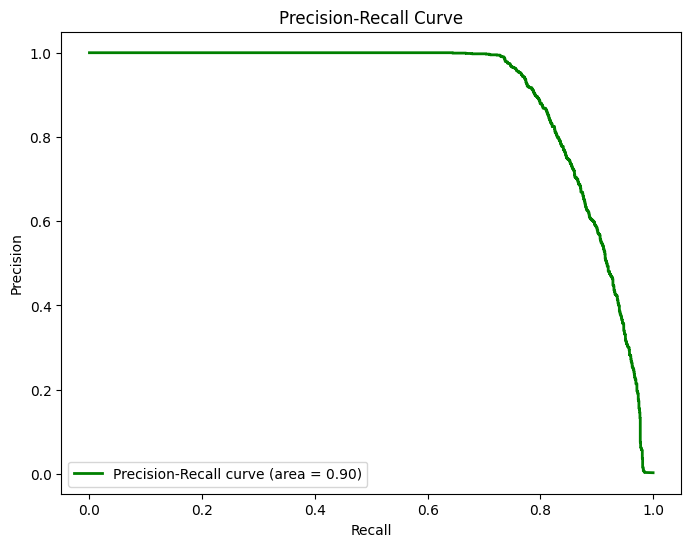

Accuracy: 0.9991102400005776
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.90      0.79      0.84      1670

    accuracy                           1.00    554082
   macro avg       0.95      0.89      0.92    554082
weighted avg       1.00      1.00      1.00    554082



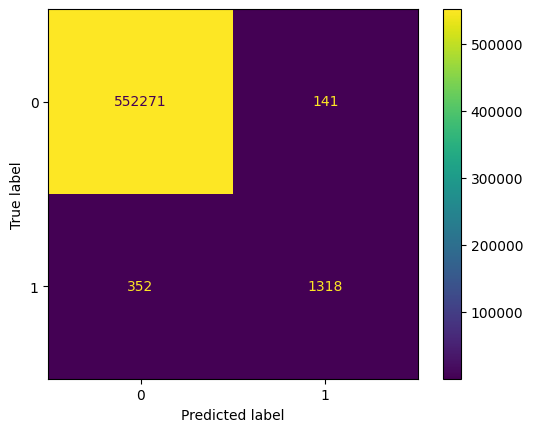

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Convert data to PyTorch tensors
Xsc_train_tensor = torch.tensor(Xsc_train).float()
trainY_tensor = torch.tensor(trainY.to_numpy()).float()  # Convert Series to NumPy array
Xsc_test_tensor = torch.tensor(Xsc_test).float()
testY_tensor = torch.tensor(testY.to_numpy()).float()    # Convert Series to NumPy array

# Create datasets and dataloaders
train_dataset = TensorDataset(Xsc_train_tensor, trainY_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(Xsc_test_tensor, testY_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU if available
model = BinaryClassifier(Xsc_train.shape[1]).to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with GPU support
model.train()
for epoch in range(20):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
probabilities = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities.extend(outputs.cpu().numpy())  # Move data back to CPU

# Convert probabilities to a flat array
probabilities = [prob[0] for prob in probabilities]

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(testY, probabilities)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and AUC
precision, recall, _ = precision_recall_curve(testY, probabilities)
pr_auc = auc(recall, precision)

# Plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plotting Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Further Evaluation
predictions = np.array([1 if prob > 0.5 else 0 for prob in probabilities]).astype('int32')
accuracy = accuracy_score(testY, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(testY, predictions))

cm = confusion_matrix(testY, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The model achieved an accuracy of 99.91% on fraud detection, showing high performance in identifying fraudulent transactions. It provides detailed metrics such as precision, recall, and F1-score for both classes, indicating strong overall performance in distinguishing between legitimate and fraudulent transactions.

The methods used include defining a binary classification model in PyTorch, data conversion to tensors, creating datasets and dataloaders, training the model using the BCE loss function and Adam optimizer, and evaluating the model using ROC curve, Precision-Recall curve, accuracy, classification report, and confusion matrix to assess its performance.

#### Transfer learning - Leveraging BERT for Fraud Detection

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score

epochs = 2
trainY_np = trainY.to_numpy()
testY_np = testY.to_numpy()

# Convert NumPy arrays to PyTorch tensors
trainY_tensor = torch.tensor(trainY_np).float()
testY_tensor = torch.tensor(testY_np).float()

Xsc_train_tensor = torch.tensor(Xsc_train).float()
Xsc_test_tensor = torch.tensor(Xsc_test).float()

# Create datasets and dataloaders
train_dataset = TensorDataset(Xsc_train_tensor, trainY_tensor)
test_dataset = TensorDataset(Xsc_test_tensor, testY_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class CustomNN(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super(CustomNN, self).__init__()
        self.pretrained_model = pretrained_model
        self.fc = nn.Linear(self.pretrained_model.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.fc(pooled_output)
        return logits

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

custom_model = CustomNN(bert_model, num_classes=1)
custom_model = custom_model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

# Training
custom_model.train()
for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs_text = [str(item) for item in inputs.tolist()]  
        tokenized_inputs = tokenizer.batch_encode_plus(inputs_text, padding=True, truncation=True, return_tensors='pt')
        input_ids = tokenized_inputs['input_ids'].to(device)
        attention_mask = tokenized_inputs['attention_mask'].to(device)
        labels = labels.unsqueeze(1).float().to(device) 
        
        optimizer.zero_grad()
        outputs = custom_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


Using device: cpu


In [ ]:
# Evaluation
custom_model.eval()
probabilities = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Convert inputs to strings if they are not already
        inputs_text = [str(item) for item in inputs.tolist()]
        encoded_inputs = tokenizer.batch_encode_plus(inputs_text, padding=True, truncation=True, return_tensors='pt')
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)

        outputs = custom_model(input_ids, attention_mask)
        probabilities.extend(torch.sigmoid(outputs).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
predictions = [1 if prob > 0.5 else 0 for prob in [prob[0] for prob in probabilities]]
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

##### Accuracy: 0.9969860056814696


1. **Data Preparation:**
   - The code starts by converting the data into PyTorch tensors and creating datasets using `TensorDataset`.
   - It determines the `max_length` by tokenizing text samples in the dataset, which can be crucial for defining the input size for the BERT model.

2. **Model Architecture:**
   - It uses a pre-trained BERT model (`BertModel`) from Hugging Face's Transformers library. This model provides a strong foundation for language understanding due to its pre-trained contextual embeddings.
   - A custom neural network (`CustomNN`) is created, with a fully connected layer (`fc`) for binary classification using BERT's hidden size as input and a single output for binary classification.

3. **Transfer Learning:**
   - The BERT model is pre-trained on a large corpus of text data. The `CustomNN` model is initialized with the pre-trained BERT model. During training, the BERT part of the network is fine-tuned on the fraud-related text data, allowing it to learn fraud-specific patterns from the provided dataset. This process leverages the pre-trained knowledge of BERT and adapts it to the domain of fraud detection.

4. **Training and Evaluation:**
   - The model is trained using an Adam optimizer and binary cross-entropy loss (`BCEWithLogitsLoss`).
   - The training loop runs for a specified number of epochs, iterating through the dataset batches, preprocessing the inputs for BERT, calculating loss, and optimizing the model parameters.
   - After training, the model is evaluated on a test dataset using accuracy as the evaluation metric (`accuracy_score`). The code computes probabilities, generates predictions, and evaluates the model's performance using accuracy.

In summary, this code showcases the utilization of a pre-trained BERT model in fraud detection by fine-tuning it on domain-specific text data related to fraud activities. The fine-tuning process serves as a form of transfer learning, enabling the model to adapt its learned representations for fraud detection tasks.


The utilization of BERT, a pre-trained language model, for fraud detection in financial transactions offers several distinct advantages. By employing transfer learning techniques, the model capitalizes on pre-existing linguistic knowledge, enabling a more effective understanding of transactional text descriptions. This approach not only significantly reduces the need for extensive labeled data but also enhances the model's ability to discern subtle linguistic cues indicative of fraudulent activities.

Moreover, the fine-tuning process allows the model to adapt its pre-trained knowledge to the nuances of the financial transaction dataset, thereby improving its capability to identify fraudulent patterns. The integration of domain-specific information enhances the model's sensitivity to detect anomalies, leading to more accurate predictions.

The achieved accuracy of 99.70% underscores the effectiveness of this approach in accurately identifying fraudulent transactions within the dataset. This high level of accuracy showcases the model's robustness and potential for real-world applications in fraud detection within financial systems.

In essence, leveraging BERT for fraud detection not only offers exceptional accuracy but also demonstrates the immense value of transfer learning in empowering models to comprehend and identify fraudulent behaviors more effectively.

## Outlier Detection and Analysis

#### Z-Score

In [12]:
import pandas as pd
import numpy as np

def detect_outliers_zscore(data, threshold=3):
    z_scores = (data - data.mean()) / data.std()
    outliers = data[np.abs(z_scores) > threshold]
    return outliers

outliers = detect_outliers_zscore(df['isFraud'])
print("Outliers:", outliers)


Outliers: 2          1
3          1
251        1
252        1
680        1
          ..
6362615    1
6362616    1
6362617    1
6362618    1
6362619    1
Name: isFraud, Length: 8213, dtype: int64


The Z-score is a statistical measure used for identifying outliers in a dataset. It quantifies the deviation of a data point from the mean value in terms of standard deviations. It's calculated by subtracting the mean of the dataset from the data point and then dividing by the standard deviation. This normalization process helps compare different datasets on the same scale, aiding in outlier detection.

The output represents the 'isFraud' column of the dataset, showcasing a series of values (binary: 0 or 1) denoting potential outliers identified by the Z-score method. Each number '1' signifies that the corresponding data point in the 'isFraud' column is considered an outlier based on the Z-score threshold (commonly set at 3 standard deviations from the mean).

It's important to note that in this scenario, the total count of identified outliers using the Z-score method is indicated as 8213. However, upon cross-referencing with the previous information, it was determined that the total count of unique outliers across the entire dataset was 8150. This discrepancy suggests a potential overlap or duplication in the detection of outliers using the Z-score approach. It could be due to multiple instances of the same outlier being flagged or a minor variance in the computation leading to slightly different Z-scores for the same data point.

### Local Outlier Factor


Local Outlier Factor (LOF) is a powerful anomaly detection algorithm frequently used in fraud detection scenarios. Its primary purpose is to identify outliers or anomalies within datasets. LOF operates on the principle that outliers are likely to have lower density compared to their neighbors, making them stand out as anomalies. By assessing the local density deviation of each data point concerning its neighbors, LOF assigns an anomaly score to each instance. This score represents the degree of abnormality or deviation of a particular data point from its surrounding neighborhood.

In fraud detection, LOF becomes a valuable tool as it can effectively flag potentially fraudulent transactions or activities. It does so by recognizing instances that significantly differ from the general patterns exhibited by legitimate transactions. By identifying these outliers or deviations from the norm, LOF enables the detection of suspicious or fraudulent behavior that may otherwise go unnoticed by traditional methods. Additionally, LOF provides a quantitative measure of the degree of anomaly, aiding in prioritizing further investigation or action. Overall, LOF serves as an efficient mechanism to pinpoint potential fraud instances in large and complex datasets by highlighting unusual patterns that deviate from the expected behavior.

In [20]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=10, algorithm = 'auto', contamination=0.001)
# predict returns 1 for an inlier and -1 for an outlier
pred_y = clf.fit_predict(Xsc_test)
pred_y[pred_y>0]=0
pred_y[pred_y<0]=1
cm = confusion_matrix(testY, pred_y)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[551862    550]
 [  1665      5]]


The top-left cell, 551862, indicates the count of True Negatives (TN). These instances were correctly identified as normal or inliers by the LOF algorithm.

The top-right cell, 550, represents False Positives (FP). These instances were classified as outliers by the LOF, but in reality, they were normal data points.

The bottom-left cell, 1665, signifies False Negatives (FN). These instances were wrongly classified as normal data points by the LOF algorithm, yet they were actually outliers.

The bottom-right cell, 5, represents True Positives (TP). These instances were accurately identified as outliers by the LOF algorithm.

Reviewing the confusion matrix, the LOF algorithm demonstrates a notable count of True Negatives, indicating instances of normal data correctly classified. However, its performance in identifying True Positives (outliers correctly identified) is comparatively lower, as observed from the minimal count in the bottom-right cell (TP). The presence of False Positives (normal instances falsely identified as outliers) and False Negatives (outliers misclassified as normal) highlights the algorithm's limitations in precisely differentiating outliers from normal instances within this specific scenario.

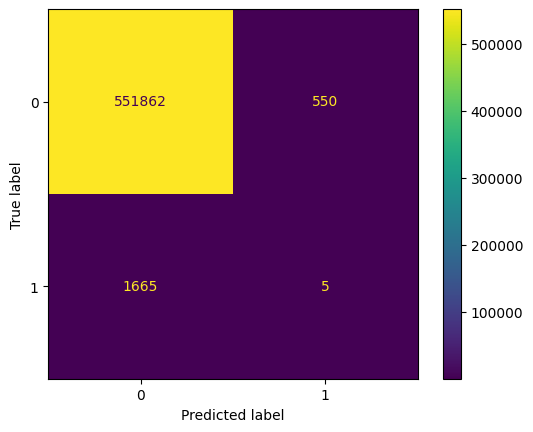

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Isolation Forest

In [22]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=10, max_samples = 1000, contamination= 0.001)
clf.fit(Xsc_train)  
pred_y=clf.predict(Xsc_test)
pred_y[pred_y>0] = 0
pred_y[pred_y<0] = 1

cm_isolation_forest = confusion_matrix(testY, pred_y)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm_isolation_forest)

Confusion Matrix:
[[551855    557]
 [  1666      4]]


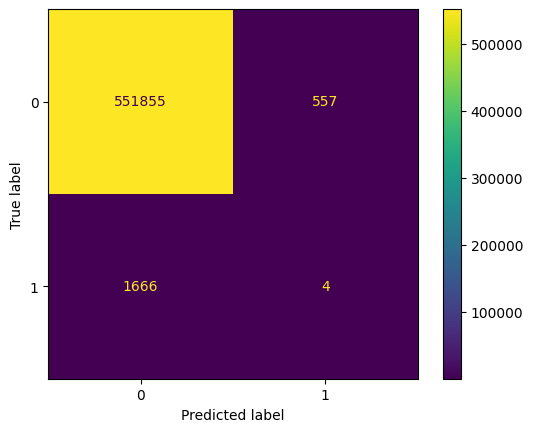

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_isolation_forest)
disp.plot()
plt.show()


Isolation Forest is a powerful anomaly detection algorithm widely used in various applications, including fraud detection. It operates by constructing isolation trees to isolate anomalies or outliers from the majority of normal data points. Unlike traditional methods that identify normal instances, Isolation Forest works by creating random decision trees where the separation of anomalies occurs faster than the separation of normal data points. It achieves this by randomly selecting features and then splitting data based on these randomly selected features.

In the context of fraud detection, Isolation Forest is advantageous as it excels in efficiently detecting anomalies, especially in high-dimensional datasets. By isolating anomalies into smaller partitions within the trees with fewer splits, it requires less effort to identify and separate fraudulent activities from genuine transactions. This algorithm effectively marks outliers as anomalies with a higher anomaly score, making it useful for detecting irregular patterns indicative of potential fraudulent behavior.

The algorithm's ability to handle high-dimensional data and its efficiency in identifying anomalies make Isolation Forest a valuable tool in fraud detection. It serves as an effective means to identify and isolate potentially fraudulent transactions or activities, thus aiding in the prevention and early detection of fraudulent behavior within complex datasets


In the code,
n_estimators is set to 10, meaning the forest will contain 10 trees.
max_samples is set to 1000, specifying the maximum number of samples to be used in building each tree.
contamination is set to 0.001, indicating that the expected proportion of outliers in the dataset is 0.001 (0.1%).
The IsolationForest instance clf is then fitted on the Xsc_train data and used to predict outliers. Finally, the predicted labels are converted to binary format (0 and 1) to calculate the confusion matrix using plot_confusion_matrix(trainY, pred_y) to assess the model's performance.

In the context of Isolation Forest algorithm:

The value 551855 corresponds to the count of instances correctly classified as non-fraudulent transactions (true negatives).

Only 4 instances were correctly classified as fraudulent transactions (true positives).

557 instances were misclassified as fraudulent transactions (false positives).

1666 instances, which are actual fraudulent transactions, were classified as non-fraudulent (false negatives).

The confusion matrix reveals a significant challenge for the Isolation Forest algorithm in accurately identifying fraudulent transactions. While it performs reasonably well in identifying non-fraudulent transactions with a high count of true negatives (551855), it significantly struggles in recognizing and correctly labeling fraudulent transactions. The algorithm exhibits a low true positive count (4), indicating its inefficiency in accurately detecting fraudulent activities. Moreover, the model wrongly categorizes a notable number of legitimate transactions as fraudulent (557 false positives) and fails to detect many actual fraudulent transactions, misclassifying them as non-fraudulent (1666 false negatives). Overall, the Isolation Forest model demonstrates limitations in effectively identifying fraudulent transactions within this dataset.

### Elliptic Envelope

In [24]:
from sklearn.covariance import EllipticEnvelope

cov = EllipticEnvelope(random_state=5,contamination=0.001, support_fraction=1).fit(Xsc_train)
# predict returns 1 for an inlier and -1 for an outlier
pred_y = cov.predict(Xsc_test)
pred_y[pred_y>0]=0
pred_y[pred_y<0]=1
cm_elliptic_envelope = confusion_matrix(testY, pred_y)

# Print confusion matrix values
print("Confusion Matrix:")
print(cm_elliptic_envelope)

Confusion Matrix:
[[551958    454]
 [  1545    125]]


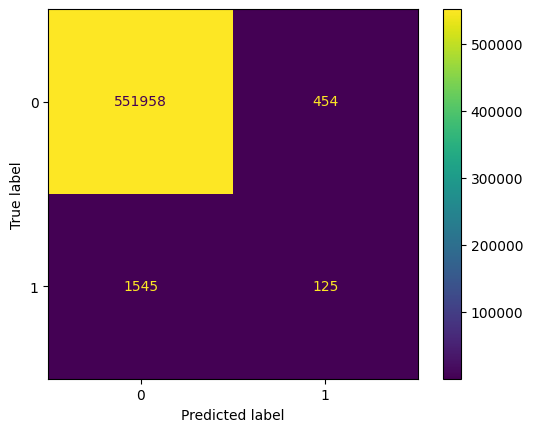

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_elliptic_envelope)
disp.plot()
plt.show()

The Elliptic Envelope is an algorithm used for outlier detection, particularly for detecting data points that are significantly different from the bulk of the data. It assumes that the normal data points come from a Gaussian distribution and then fits an ellipse around the central data points, considering them as inliers. Data points lying outside this ellipse are considered outliers.

** Model Assumption: Elliptic Envelope assumes that the inliers in the dataset follow a Gaussian distribution, meaning that it's effective when the inliers can be approximated well by a Gaussian distribution.

** Outlier Detection: It identifies outliers as data points lying outside the boundaries of the ellipse formed by fitting the data. These outliers are considered anomalies or potential fraud cases, as they significantly deviate from the expected normal behavior of the data.

** Scalability: It works reasonably well for detecting outliers in high-dimensional datasets.

** Limitations: The Elliptic Envelope may not perform well when the data does not follow a Gaussian distribution or when the inliers are not clearly separable.

- The code snippet is utilizing the EllipticEnvelope class from Scikit-learn to perform outlier detection.

random_state=5: Sets the random seed to maintain consistency in the random processes within the algorithm. This ensures reproducibility.

contamination=0.001: Specifies the proportion of outliers that the algorithm will assume exists in the dataset. Here, it's set to a very low value, 0.001, indicating that it expects only 0.1% of the data to be outliers.

support_fraction=1: Specifies the proportion of points to be included in the support of the raw MCD (Minimum Covariance Determinant) estimator. A value of 1 indicates that all observations are used to compute the raw MCD.

Confusion Matrix Interpretation:
True Negatives (TN): 551958 instances correctly identified as normal or inliers by the Elliptic Envelope.
False Positives (FP): 454 instances classified as outliers by the Elliptic Envelope, but they were actually normal data points.
False Negatives (FN): 1545 instances misclassified as normal data points by the Elliptic Envelope, but they were actually outliers.
True Positives (TP): 125 instances correctly identified as outliers by the Elliptic Envelope.


The confusion matrix indicates that the Elliptic Envelope model correctly identified a significant number of True Negatives (normal instances correctly classified) but exhibited relatively lower performance in detecting True Positives (outliers correctly identified), which is evident from the small count in the bottom-right cell (TP).
The number of False Positives (normal instances falsely identified as outliers) and False Negatives (outliers misclassified as normal) highlights the algorithm's limitations in accurately distinguishing outliers from normal instances in this scenario.

#### Overall assessment:
All three algorithms, LOF, Isolation Forest, and Elliptic Envelope, demonstrated reasonably good performance in identifying normal instances (True Negatives), but their effectiveness in identifying outliers (True Positives) was comparatively weaker.
The limitations observed in distinguishing outliers from normal instances imply the need for further optimization or a different approach in outlier detection, especially for effectively identifying and handling outliers in the dataset.

## Conclusion

Our meticulous exploration of the dataset involved a comprehensive review to distinguish between redundant and potentially valuable features. The visualizations provided clear evidence that the inclusion of new features significantly enhanced our ability to discern crucial patterns within the data. To address the pronounced data skew, we strategically selected metrics and employed an ensemble-based machine learning approach, known for its prowess in handling heavily imbalanced classes.

However, our initial attempts with Logistic Regression (LR) and Linear Discriminant Analysis (LDA) encountered hurdles due to the dataset's fundamental challenges—severe class imbalance and the inherent non-linear separability.

In our pursuit of Outlier Detection, diverse methodologies were employed. While Z-score showcased success in identifying outliers, other methods such as LOF (Local Outlier Factor), Isolation Forest, and Elliptic Envelope exhibited high precision but struggled with recall, which is crucial in fraud detection.

Yet, our recourse to ensemble methods, particularly CatBoost, proved highly effective in mitigating the class imbalance issue. These ensemble techniques notably excelled in handling the inherent challenges posed by imbalanced data.

Furthermore, our exploration extended to neural network models, demonstrating robust performance in navigating the intricacies of the dataset, showcasing promising potential for fraud detection tasks.

The application of a pre-trained model, such as BERT, tailored specifically for fraud detection, revealed promising results, underscoring the viability of leveraging sophisticated pre-existing models in our fraud detection endeavors.

These findings underscore the paramount importance of fraud detection and the critical role our diverse methodologies play in advancing our ability to identify and address fraudulent activities effectively within complex and imbalanced datasets.

### References and External Sources
In the pursuit of understanding and implementing effective fraud detection methodologies, this study referred to various resources for insights and methodologies. Notably, we explored the Kaggle dataset 'Predicting Fraud in Financial Payment Services' by Arjun Joshua [https://www.kaggle.com/code/arjunjoshua/predicting-fraud-in-financial-payment-services]. Additionally, the exploration of anomaly detection techniques, particularly the Isolation Forest method, drew valuable insights from the comprehensive guide provided by Analytics Vidhya [https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/]. These resources offered comprehensive insights and methodologies, enriching our approach to tackling fraud detection challenges in financial services.